# First: load imports needed for the project and preparation of the project

In [1]:
# This cell is necessary to use this notebook in google colab
# If you are running this notebook in colab, please change colab to True

import os

colab = True
cwd = os.getcwd()

if colab is True and cwd != "/content/Bsc_Thesis":
  ! git clone https://github.com/SergioTallo/Bsc_Thesis.git
  % cd Bsc_Thesis

print(cwd)

Cloning into 'Bsc_Thesis'...
remote: Enumerating objects: 224, done.
remote: Counting objects: 100% (224/224), done.
remote: Compressing objects: 100% (212/212), done.
remote: Total 224 (delta 140), reused 26 (delta 12), pack-reused 0
Receiving objects: 100% (224/224), 4.01 MiB | 1.06 MiB/s, done.
Resolving deltas: 100% (140/140), done.
/content/Bsc_Thesis
/content


In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import math
from torch import Tensor, float32, sin, cos
import torch.nn as nn
import matplotlib.pyplot as plt
import utils_bsc
import datetime
import statistics
import seaborn as sns
from datetime import datetime
from tqdm import tqdm

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Device: GPU =', torch.cuda.get_device_name(0))
else:
  device = torch.device('cpu')
  print('Device: CPU')


Device: GPU = Tesla T4


In [3]:
utils_bsc.print_versions()

versions of packages:
Python: 3.7.13
Pandas: 1.3.5
Numpy: 1.21.6
PyTorch: 1.10.0+cu111
Sklearn: 1.0.2
seaborn: 0.11.2


# Data loading and preparation

Now, we should create a dataset with all the data stored in the .csv file

Description of the data:

*   time: Timestamp (YYYY-MM-DD HH:MM:SS)
*   PLN1: Power in the phase 1 (W)
*   PLN2: Power in the phase 2 (W)
*   PLN3: Power in the phase 3 (W)
*   ULL1: Current Voltage between 2 phases (V)
*   ULL2: Current Voltage between 2 phases (V)
*   ULL3: Current Voltage between 2 phases (V)
*   COS_PHI1: Phase shift (Cos)
*   COS_PHI2: Phase shift (Cos)
*   COS_PHI3: Phase shift (Cos)
*   FREQ: Electricity Frequency (Hz)
*   RC_DC: Fault currents
*   RC_AC: Fault currents
*   RC_50Hz: Fault currents
*   RC_150Hz: Fault currents
*   RC_<100Hz: Fault currents
*   RC_100Hz-1kHz: Fault currents
*   RC_>10kHz: Fault currents


In [4]:
dataset = pd.read_csv('data_factory.csv')
dataset.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,1141.0819,519.5034,482.9381,398.8613,400.1982,395.6010,0.8091,0.6864,0.4875,49.9927,4.0,91.0,10.0,39.0,36.0,86.0,82.0,7.0
1,2020-06-01 00:01:00,1145.1162,519.1807,491.4436,398.6934,400.1579,395.5431,0.8080,0.6903,0.4904,49.9779,5.0,64.0,7.0,27.0,25.0,60.0,55.0,2.0
2,2020-06-01 00:02:00,1140.9558,743.3837,484.9942,398.4367,400.1205,395.5259,0.8113,0.9274,0.4806,49.9782,4.0,64.0,7.0,27.0,25.0,60.0,55.0,2.0
3,2020-06-01 00:03:00,1151.9409,741.4836,487.4224,398.9800,400.4375,395.8621,0.8249,0.9123,0.4778,49.9850,5.0,66.0,8.0,28.0,25.0,61.0,57.0,2.0
4,2020-06-01 00:04:00,1142.1594,741.9858,486.7629,398.7133,400.3145,395.6446,0.8081,0.9291,0.4552,49.9856,4.0,85.0,11.0,45.0,41.0,75.0,68.0,6.0


Once we have the dataset, we should prepare it. Finding the missing or the NaN values and replace them with suitable values (in this case we use the previous value).

In [5]:
# Replace all mising values with NaN
dataset = dataset.replace(' ', np.nan)
# Search for all the rows with NaN values
nan_values = dataset[dataset.isna().any(axis=1)]
# Print the shape to know how many are there
print(f'Number of rows with NaN values before cleaning: {nan_values.shape[0]}') 

# Fill all NaN values with the previous row value
dataset_clean = dataset.fillna(method='ffill')

# Check that there isn't any NaN values
nan_values = dataset_clean[dataset_clean.isna().any(axis=1)]
# Print the shape to know how many are there
print(f'Number of rows with NaN values after cleaning: {nan_values.shape[0]}') 

#Total number of samples
print(f'Total number of samples: {dataset_clean.shape[0]}')
print(f'Number of features: {dataset_clean.shape[1]}')

Number of rows with NaN values before cleaning: 2546
Number of rows with NaN values after cleaning: 0
Total number of samples: 63360
Number of features: 19


# Distribution of the data

Now we look at the distribution of the different features of the data over different time intervals.
First we take a look of the min and max values, mean and median value and the standard deviation of every feature.

In [6]:
print_data = False

if print_data is True:
  for column in dataset_clean.columns:
    if column == 'time':
      print(column)
      print('Min value: ', dataset_clean[column].min())
      print('Max value: ', dataset_clean[column].max())
      print('')
    else:
      print(column)
      print('Min value: ', dataset_clean[column].min())
      print('Max value: ', dataset_clean[column].max())
      print('Mean value: ', dataset_clean[column].mean())
      print('Median value: ', dataset_clean[column].median())
      print('Standard deviation: ', dataset_clean[column].std())
      print('')

In [7]:
# Set to True to print the graphs

print_graphs = False

if print_graphs is True:

  for i, column in enumerate(dataset_clean.columns):
    if i > 0:
      # Feature in a weekly interval
      utils_bsc.week_plot(dataset_clean, i, column)
      # Feature in a daily interval (only the values of weekdays between 4:00 and 19:30)
      utils_bsc.daily_plot(dataset_clean, i, column)

In [8]:
# We print some graphs showing the density distribution of every feature

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_clean.columns):
    if column != 'time':
      sns.displot(dataset_clean, x=column, kind="kde")

After looking to the different data graphs i notice there two very different "time slots" when the data differs. One is Weekdays between 4:00 and 19:30. The other is Weekdays bewteen 19:30 and 4:00 and Weekends.

In [9]:
# We create two extra data sets, one with the weekdays between 4:00 and 18:30 and one with the rest.
dataset_clean_time = pd.to_datetime(dataset_clean['time'])

day_mask = dataset_clean_time.dt.day_name()

time_mask = (dataset_clean_time.dt.hour >= 4) & ((dataset_clean_time.dt.hour < 19) | ((dataset_clean_time.dt.hour == 19) & (dataset_clean_time.dt.minute <= 30))) & ((day_mask == ('Monday')) | (day_mask == ('Tuesday')) | (day_mask == ('Wednesday')) | (day_mask == ('Thursday')) | (day_mask == ('Friday')))

dataset_weekdays = dataset_clean[time_mask]

for i in range(len(time_mask)):
  if time_mask[i] == False:
    time_mask[i] = True
  elif time_mask[i] == True:
    time_mask[i] = False

dataset_weekend = dataset_clean[time_mask]

print(f'Weekdays dataset size: {len(dataset_weekdays)}')
print(f'Weekend dataset size: {len(dataset_weekend)}')

Weekdays dataset size: 29792
Weekend dataset size: 33568


In [10]:
print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekdays.columns):
    if column != 'time':
      sns.displot(dataset_weekdays, x=column, kind="kde")

In [11]:
print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekend.columns):
    if column != 'time':
      sns.displot(dataset_weekend, x=column, kind="kde")

At this time we have three different datasets:

* dataset_clean (Whole dataset)
* dataset_weekdays (Entries from weekdays from 4:00 to 19:30)
* dataset_weekend (Entries from Weekends and from weekdays from 19:30 to 4:00)



# Dataset normalisation

The scale of the data of the different features is very dofferent. Its better to have all of the features in the same scale. Therefore we perform a data normalisation. We choose to do a mean/stddev normalisation. We substract from every value the mean value of the feature and divide the result value by the std dev of this specific feature to have feature values with mean 0 and stddev of 1.

In [12]:
# apply the mean / stddev scaling in Pandas using the .mean() and .std() methods
def normalize_mean_std_dataset(df):
    # copy the dataframe
    df_norm = df.copy()
    # apply mean / stddev scaling
    for column in tqdm(df_norm.columns):
      if column != 'time':
        df_norm[column] = (df_norm[column] - df_norm[column].mean()) / df_norm[column].std()
    return df_norm

In [13]:
# Perform the data normalisation in the whole dataset. We can print the distribution of the data if we want.
dataset_norm = normalize_mean_std_dataset(dataset_clean)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_norm.columns):
    if column != 'time':
      sns.displot(dataset_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 712.20it/s]


In [14]:
# Perform the data normalisation in the weekdays dataset. We can print the distribution of the data if we want.
dataset_weekdays_norm = normalize_mean_std_dataset(dataset_weekdays)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekdays_norm.columns):
    if column != 'time':
      sns.displot(dataset_weekdays_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 846.66it/s]


In [15]:
# Perform the data normalisation in the weekdays dataset. We can print the distribution of the data if we want.
dataset_weekend_norm = normalize_mean_std_dataset(dataset_weekend)

print_graphs = False

if print_graphs is True:
  for column in tqdm(dataset_weekend_norm.columns):
    if column != 'time':
      sns.displot(dataset_weekend_norm, x=column, kind="kde")

100%|██████████| 19/19 [00:00<00:00, 1019.17it/s]


In [16]:
dataset_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,-1.075593,-1.045021,-1.051232,0.063478,-0.098312,-0.618908,-1.868350,-1.835847,-1.500292,-0.345935,-0.817380,0.632551,1.075812,0.995360,1.143832,0.694697,0.747095,2.141318
1,2020-06-01 00:01:00,-1.074875,-1.045103,-1.048747,0.027004,-0.107515,-0.632738,-1.884005,-1.803753,-1.486828,-1.139728,0.678985,-0.849829,-0.918340,-0.792166,-0.630653,-0.822036,-0.777047,-1.175568
2,2020-06-01 00:02:00,-1.075615,-0.988316,-1.050631,-0.028760,-0.116055,-0.636846,-1.837041,0.147415,-1.532327,-1.123638,-0.817380,-0.849829,-0.918340,-0.792166,-0.630653,-0.822036,-0.777047,-1.175568
3,2020-06-01 00:03:00,-1.073661,-0.988798,-1.049922,0.089264,-0.043667,-0.556540,-1.643493,0.023152,-1.545327,-0.758922,0.678985,-0.740023,-0.253623,-0.643206,-0.630653,-0.763700,-0.664147,-1.175568
4,2020-06-01 00:04:00,-1.075401,-0.988670,-1.050114,0.031327,-0.071754,-0.608493,-1.882582,0.161405,-1.650254,-0.726741,-0.817380,0.303134,1.740530,1.889123,1.950416,0.053002,-0.043201,1.477941


In [17]:
dataset_weekdays_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
240,2020-06-01 04:00:00,-3.844526,-2.815111,-3.811858,1.679619,1.570822,1.782563,-1.458455,-0.043591,-11.695581,-0.570289,-0.884008,-3.224201,-1.568103,-1.701045,-1.466370,-3.271799,-2.865462,-1.695805
241,2020-06-01 04:01:00,-3.846186,-3.787824,-3.823188,1.763631,1.696076,1.843617,-1.467086,-2.835547,-11.782866,0.903443,2.133621,-3.224201,-1.568103,-1.701045,-1.466370,-3.357651,-2.939190,-1.695805
242,2020-06-01 04:02:00,-3.839272,-1.875102,-2.712874,1.852445,1.730759,1.917486,-1.557711,0.058113,-1.543490,0.445873,0.624807,-1.273229,-0.765503,-1.118658,-0.885575,-1.211362,-0.948518,-0.928865
243,2020-06-01 04:03:00,-3.842709,-3.088604,-3.827000,1.832063,1.744944,1.905749,-1.475716,-0.716154,-12.237347,-0.219683,0.624807,-1.923553,-1.568103,-1.312787,-1.272772,-2.069878,-1.538347,-0.928865
244,2020-06-01 04:04:00,-3.844287,-2.842539,-3.450520,1.753998,1.623568,1.808403,-1.527502,-0.430725,-5.973931,-0.611886,-0.884008,-1.842262,-0.765503,-1.312787,-1.272772,-2.069878,-1.464618,-0.928865


In [18]:
dataset_weekend_norm.head()

,time,PLN1,PLN2,PLN3,ULL1,ULL2,ULL3,COS_PHI1,COS_PHI2,COS_PHI3,FREQ,RC_DC,RC_AC,RC_50Hz,RC_150Hz,RC_<100Hz,RC_100Hz-1kHz,RC_>1kHz,RC_>10kHz
0,2020-06-01 00:00:00,-0.520051,-0.469417,-0.491179,-0.852017,-1.003068,-1.783292,-1.338808,-1.189834,-0.885658,-0.479759,-0.761410,1.276387,1.388355,1.509262,1.555410,1.427389,1.381491,2.307679
1,2020-06-01 00:01:00,-0.518390,-0.469592,-0.485656,-0.905465,-1.016009,-1.803094,-1.356629,-1.159350,-0.870606,-1.233069,0.728477,-0.330467,-0.570467,-0.350376,-0.254028,-0.283821,-0.298828,-0.881879
2,2020-06-01 00:02:00,-0.520102,-0.348132,-0.489844,-0.987181,-1.028018,-1.808977,-1.303165,0.693881,-0.921471,-1.217799,-0.761410,-0.330467,-0.570467,-0.350376,-0.254028,-0.283821,-0.298828,-0.881879
3,2020-06-01 00:03:00,-0.515582,-0.349161,-0.488267,-0.814230,-0.926227,-1.693993,-1.082826,0.575856,-0.936003,-0.871684,0.728477,-0.211441,0.082473,-0.195407,-0.254028,-0.218005,-0.174360,-0.881879
4,2020-06-01 00:04:00,-0.519607,-0.348889,-0.488696,-0.899130,-0.965723,-1.768380,-1.355009,0.707168,-1.053303,-0.841144,-0.761410,0.919308,2.041296,2.439081,2.377882,0.703416,0.510214,1.669767


At this moment we have six different datasets to use:
* dataset_clean (Whole dataset)
* dataset_weekdays (Entries from weekdays from 4:00 to 19:30)
* dataset_weekend (Entries from Weekends and from weekdays from 19:30 to 4:00)
* dataset_norm (Whole dataset, mean/stddev normalised)
* dataset_weekdays_norm (Entries from weekdays from 4:00 to 19:30, mean/stddev normalised)
* dataset_weekend_norm (Entries from Weekends and from weekdays from 19:30 to 4:00, mean/stddev normalised)

Covariance matrix of all features

(63360, 18)
<class 'numpy.float64'>


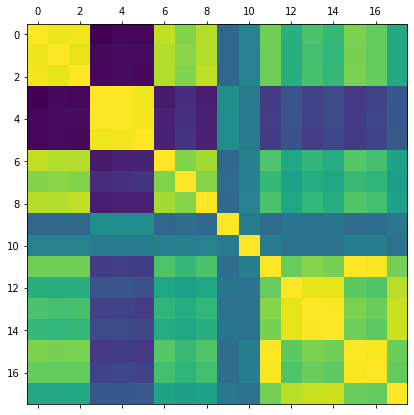

[9.572 2.940 1.352 0.989 0.970 0.891 0.405 0.251 0.230 0.177 0.072 0.052
 0.039 0.031 0.012 0.004 0.004 0.007]
[0.5317647804810275, 0.16335739298653454, 0.07511546472383007, 0.054921627068028396, 0.05390616867076576, 0.04952232661739347, 0.02248634946399557, 0.013932731902136307, 0.012792662672300404, 0.00982901200719907, 0.004024926426955618, 0.0028939596101033747, 0.002163271201445894, 0.001741116222641514, 0.0006928432299861942, 0.000218263374261013, 0.00023351820917082356, 0.00040358513222439905]


In [19]:
import matplotlib.pyplot as plt

set_ = dataset_norm.iloc[:,1:].values

print(set_.shape)
print(type(set_[0][0]))

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cov_matrix = np.cov(set_.T)

fig = plt.figure(figsize=(15, 15))

# Adds subplot on position 1
ax = fig.add_subplot(121)
ax.matshow(cov_matrix)
plt.show()

eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

print(eigenvalues)

explained_variance = []

for i in eigenvalues:
    explained_variance.append(i/sum(eigenvalues))

print(explained_variance)

# Correlation between features

In [20]:
correlations = []
matrix = []

for i in dataset_norm.columns[1:]:
  feature = []
  for j in dataset_norm.columns[1:]:
    print(f'Correlation between {i} and {j}')
    correlation = np.corrcoef(dataset_norm[i], dataset_norm[j])
    if i != j:
      correlations.append(abs(correlation[0][1]))
      feature.append(abs(correlation[0][1]))
      print(correlation[0][1])
  print(f'Mean of {i} correlations: {np.mean(feature)}')
  print('')
  matrix.append(feature)

print(f'Mean of all correlations: {np.mean(correlations)}')

Correlation between PLN1 and PLN1
Correlation between PLN1 and PLN2
0.9530638927686162
Correlation between PLN1 and PLN3
0.960666498797786
Correlation between PLN1 and ULL1
-0.7274016376341783
Correlation between PLN1 and ULL2
-0.6955282277514698
Correlation between PLN1 and ULL3
-0.703083541005038
Correlation between PLN1 and COS_PHI1
0.8410401295195364
Correlation between PLN1 and COS_PHI2
0.6731338062873102
Correlation between PLN1 and COS_PHI3
0.8122370309192152
Correlation between PLN1 and FREQ
-0.15451597949699267
Correlation between PLN1 and RC_DC
0.041447902380906156
Correlation between PLN1 and RC_AC
0.6311099014117805
Correlation between PLN1 and RC_50Hz
0.3688113546135118
Correlation between PLN1 and RC_150Hz
0.5078743784519381
Correlation between PLN1 and RC_<100Hz
0.4309325330867658
Correlation between PLN1 and RC_100Hz-1kHz
0.6585953463453895
Correlation between PLN1 and RC_>1kHz
0.5928797475823846
Correlation between PLN1 and RC_>10kHz
0.3161918341465537
Mean of PLN1 cor

In [21]:
for i in range(len(matrix)):
  print(matrix[i])

[0.9530638927686162, 0.960666498797786, 0.7274016376341783, 0.6955282277514698, 0.703083541005038, 0.8410401295195364, 0.6731338062873102, 0.8122370309192152, 0.15451597949699267, 0.041447902380906156, 0.6311099014117805, 0.3688113546135118, 0.5078743784519381, 0.4309325330867658, 0.6585953463453895, 0.5928797475823846, 0.3161918341465537]
[0.9530638927686162, 0.9452605980705134, 0.6920070109902807, 0.67045662332035, 0.6734582119423179, 0.798636597184364, 0.7023352006830498, 0.8038123821731527, 0.1421352786738536, 0.039207762733898116, 0.6232451337648504, 0.35899547217519384, 0.49084689121247477, 0.4172313931163453, 0.6488235868701705, 0.589166395252223, 0.3118843831224033]
[0.960666498797786, 0.9452605980705134, 0.7002177438968478, 0.6722798995076359, 0.6821156558367125, 0.8022338627218533, 0.6694582338358988, 0.8313797068885327, 0.1496748710465221, 0.04088450891644735, 0.6281657734892852, 0.3656352287662722, 0.49896359795411893, 0.4239534499789887, 0.6539236685512887, 0.5911138593179

# Preparation Training and Test set

Once the dataset is prepared, make batches of data,put them togheter in an array and split them into train and test sets.
After looking through the dataset and the features, i decided to takeonly the values with a timestap of a weekday between 4:00 and 19:30. In many of the features in the interval outside those timestamps there i only noise, which can be a sign that the machine is off in that time interval.

In [22]:
def create_dataloaders(dataset_norm):

  # Create a dataset with pairs data / Target (in this case data is one measure (18 features) and target is the next measure (18 features))
  # When you plug in one measure, the model should out the next measure

  pair_set = []

  for i in tqdm(range(len(dataset_norm) -1)):
    data = np.array([j for j in dataset_norm.iloc[i, 1:]])
    target = np.array([j for j in dataset_norm.iloc[i+1, 1:]])
    
    pair_set.append((data, target))

  dataset_pairs = np.array(pair_set)

  training_data_pairs, testing_data_pairs = train_test_split(dataset_pairs, test_size=0.1, random_state=25)

  data = []
  target = []
  for i in training_data_pairs:
    data.append(i[0])
    target.append(i[1])

  training_data = torch.from_numpy(np.array(data)).float().to(device)
  training_target = torch.from_numpy(np.array(target)).float().to(device)

  data = []
  target = []
  for i in testing_data_pairs:
    data.append(i[0])
    target.append(i[1])

  test_data = torch.from_numpy(np.array(data)).float().to(device)
  test_target = torch.from_numpy(np.array(target)).float().to(device)

  print(f'length of training set (whole dataset): {training_data.shape[0]}')
  print(f'length of test set (whole dataset): {test_data.shape[0]}')
  print('\n')

  # Create data loader to feed the FFN in mini batches

  loader_train = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(training_data, training_target),
      batch_size=64,
      shuffle=True
  )

  # Create data loader for testing the model
  loader_test = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(test_data, test_target),
      batch_size=64,
      shuffle=True
  )

  return loader_train, loader_test

In [23]:
loader_train, loader_test = create_dataloaders(dataset_norm)

100%|██████████| 63359/63359 [00:21<00:00, 3004.83it/s]


length of training set (whole dataset): 57023
length of test set (whole dataset): 6336




In [24]:
def create_sequece_dataloaders(dataset_norm):

  # Create a dataset with pairs data / Target (in this case data is one sequence of 30 measures (18 features) and target are the next sequence of 30 
  # measures (18 features)). When you plug in one measure, the model should out the next measure

  pair_set = []

  for i in tqdm(range(len(dataset_norm) - 60)):
    data = np.array(dataset_norm.iloc[i:i+30, 1:])
    target = np.array(dataset_norm.iloc[i+30:i+60, 1:])
    
    pair_set.append((data, target))

  dataset_pairs = np.array(pair_set)

  training_data_pairs, testing_data_pairs = train_test_split(dataset_pairs, test_size=0.1, random_state=25)

  data = []
  target = []
  for i in training_data_pairs:
    data.append(i[0])
    target.append(i[1])

  training_data = torch.from_numpy(np.array(data)).float().to(device)
  training_target = torch.from_numpy(np.array(target)).float().to(device)

  data = []
  target = []
  for i in testing_data_pairs:
    data.append(i[0])
    target.append(i[1])

  test_data = torch.from_numpy(np.array(data)).float().to(device)
  test_target = torch.from_numpy(np.array(target)).float().to(device)

  print(f'length of training set (whole dataset): {training_data.shape[0]}')
  print(f'length of test set (whole dataset): {test_data.shape[0]}')
  print('\n')

  # Create data loader to feed the FFN in mini batches

  loader_train = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(training_data, training_target),
      batch_size=30,
      shuffle=True
  )

  # Create data loader for testing the model
  loader_test = torch.utils.data.DataLoader(
      dataset=torch.utils.data.TensorDataset(test_data, test_target),
      batch_size=30,
      shuffle=True
  )

  return loader_train, loader_test, training_data, training_target

In [25]:
loader_train_seq, loader_test_seq, training_data_seq, training_target_seq = create_sequece_dataloaders(dataset_norm)

100%|██████████| 63300/63300 [00:20<00:00, 3087.73it/s]


length of training set (whole dataset): 56970
length of test set (whole dataset): 6330




# Create a Baseline Model

I am taking the Last step as prediction of all features to create a baselinemodel. I will use this baseline model to compare the results of the actual model with it. Everything that works better than this baseline model could be an improvement.

In [26]:
criterion = nn.MSELoss()

losses_train = []

for i in loader_train_seq:
  output = i[0]
  target = i[1]
  loss = criterion(output, target)
  losses_train.append(loss.item())

losses_test = []

for i in loader_test_seq:
  output = i[0]
  target = i[1]
  loss = criterion(output, target)
  losses_test.append(loss.item())

print("Training set")
print("Mean Loss of baselinemodel: ", np.mean(losses_train))
print("Standard deviation Loss of baselinemodel: ", np.std(losses_train))
print('\n')
print("Test set")
print("Mean Loss of baselinemodel: ", np.mean(losses_test))
print("Standard deviation Loss of baselinemodel: ", np.std(losses_test))
print('\n')

Training set
Mean Loss of baselinemodel:  0.7443867031369101
Standard deviation Loss of baselinemodel:  0.07848298680577376


Test set
Mean Loss of baselinemodel:  0.750549324880844
Standard deviation Loss of baselinemodel:  0.07939117405149039




# Train a simple Feed Forward Neural Network as a baseline model

I trained a simple FFN Network to have a second baseline model. The final model training should have also a better performance than this FFN.

In [27]:
class ANN_relu(nn.Module):

    def __init__(self, D_in, D_out):
        super(ANN_relu, self).__init__()
        self.linear1 = nn.Linear(D_in, 180)
        self.linear2 = nn.Linear(180, 640)
        self.linear3 = nn.Linear(640, 180)
        self.linear4 = nn.Linear(180, D_out)

        self.relu = torch.nn.ReLU()

        self.dropout = torch.nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)

        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.linear3(x)
        x = self.relu(x)
        x = self.dropout(x)

        return self.linear4(x)

# This function trains the model for one epoch
def train(model, criterion, optimizer, train_loader, test_loader, n_epochs):

    epoch_loss_train = []
    epoch_loss_test = []

    for e in range(1, n_epochs +1):
      print(f'\nEpoch {e}:')

      print('Train')
      model.train()

      for i in tqdm(train_loader):

        data, target = i[0], i[1]

        optimizer.zero_grad()

        # Forward Pass
        output = model(data)

        #Compute loss
        loss = criterion(output, target)

        #Backpropagation
        loss.backward()

        #Optimization
        optimizer.step()

      losses = []

      print('\nTest with training set')
      model.eval()
      with torch.no_grad():
        for i in tqdm(train_loader):

          data, target = i[0], i[1]

          output = model(data)
              
          losses.append (float(criterion(output, target).item()))

      print('\nCurrent Mean loss Train: ', np.mean(losses))
      epoch_loss_train.append(losses)

      losses = []

      print('\nTest with test set')
      model.eval()
      with torch.no_grad():
        for i in tqdm(test_loader):

          data, target = i[0], i[1]

          output = model(data)
            
          losses.append (float(criterion(output, target).item()))


      print('\nCurrent Mean loss: ', np.mean(losses))
      epoch_loss_test.append(losses)

    return model, epoch_loss_train, epoch_loss_test

In [28]:
criterion = nn.MSELoss()

losses_train = []

for i in loader_train:
  output = i[0]
  target = i[1]
  loss = criterion(output, target)
  losses_train.append(loss.item())

losses_test = []

for i in loader_test:
  output = i[0]
  target = i[1]
  loss = criterion(output, target)
  losses_test.append(loss.item())

print("Training set")
print("Mean Loss of baselinemodel: ", np.mean(losses_train))
print("Standard deviation Loss of baselinemodel: ", np.std(losses_train))
print('\n')
print("Test set")
print("Mean Loss of baselinemodel: ", np.mean(losses_test))
print("Standard deviation Loss of baselinemodel: ", np.std(losses_test))
print('\n')

Training set
Mean Loss of baselinemodel:  0.4737902336349391
Standard deviation Loss of baselinemodel:  0.09347028406433089


Test set
Mean Loss of baselinemodel:  0.46593056935252564
Standard deviation Loss of baselinemodel:  0.09732933905245504




In [29]:
n_epochs = 200
lr=0.01

# Create model FFN instance
model_FFN_whole = ANN_relu(18, 18).to(device)
print(model_FFN_whole)

# Define Loss
criterion = nn.MSELoss()

# Define Optimizer
optimizer_whole = torch.optim.SGD(model_FFN_whole.parameters(), lr=lr)


train_FFN = True

params_not_trained_whole = model_FFN_whole.parameters()

if train_FFN is True:
  trained_model_FFN_whole , train_losses_whole, test_losses_whole = train(model_FFN_whole, criterion, optimizer_whole, loader_train, loader_test, n_epochs)


ANN_relu(
  (linear1): Linear(in_features=18, out_features=180, bias=True)
  (linear2): Linear(in_features=180, out_features=640, bias=True)
  (linear3): Linear(in_features=640, out_features=180, bias=True)
  (linear4): Linear(in_features=180, out_features=18, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 1:
Train


100%|██████████| 891/891 [00:01<00:00, 523.24it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1131.75it/s]



Current Mean loss Train:  0.4621054971994107

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1146.41it/s]



Current Mean loss:  0.4558103394628775

Epoch 2:
Train


100%|██████████| 891/891 [00:01<00:00, 579.86it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1159.96it/s]



Current Mean loss Train:  0.3761615311657941

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1150.32it/s]



Current Mean loss:  0.3696687381074886

Epoch 3:
Train


100%|██████████| 891/891 [00:01<00:00, 584.79it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1151.20it/s]



Current Mean loss Train:  0.34276124053999496

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1111.64it/s]



Current Mean loss:  0.3361212373381913

Epoch 4:
Train


100%|██████████| 891/891 [00:01<00:00, 572.82it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1175.47it/s]



Current Mean loss Train:  0.3305022233028872

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1157.36it/s]



Current Mean loss:  0.3237191917318286

Epoch 5:
Train


100%|██████████| 891/891 [00:01<00:00, 581.01it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1171.45it/s]



Current Mean loss Train:  0.3232629479951195

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1188.80it/s]



Current Mean loss:  0.31589836589615755

Epoch 6:
Train


100%|██████████| 891/891 [00:01<00:00, 571.07it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1152.44it/s]



Current Mean loss Train:  0.31838582625025186

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1121.87it/s]



Current Mean loss:  0.3111022561788559

Epoch 7:
Train


100%|██████████| 891/891 [00:01<00:00, 578.90it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1124.30it/s]



Current Mean loss Train:  0.3146071493224263

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1112.09it/s]



Current Mean loss:  0.3070724681772367

Epoch 8:
Train


100%|██████████| 891/891 [00:01<00:00, 562.87it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1148.86it/s]



Current Mean loss Train:  0.31147892686186146

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1155.12it/s]



Current Mean loss:  0.303948457192893

Epoch 9:
Train


100%|██████████| 891/891 [00:01<00:00, 549.30it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1142.93it/s]



Current Mean loss Train:  0.3096391480712912

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1150.11it/s]



Current Mean loss:  0.30234977452441897

Epoch 10:
Train


100%|██████████| 891/891 [00:01<00:00, 556.30it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1115.31it/s]



Current Mean loss Train:  0.30784099501391454

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1026.89it/s]



Current Mean loss:  0.3003007325560156

Epoch 11:
Train


100%|██████████| 891/891 [00:01<00:00, 548.17it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1161.17it/s]



Current Mean loss Train:  0.3065977342568932

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1077.42it/s]



Current Mean loss:  0.29893224859478496

Epoch 12:
Train


100%|██████████| 891/891 [00:01<00:00, 549.08it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1131.42it/s]



Current Mean loss Train:  0.30550063927433174

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1106.61it/s]



Current Mean loss:  0.2979739872795163

Epoch 13:
Train


100%|██████████| 891/891 [00:01<00:00, 548.44it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1152.49it/s]



Current Mean loss Train:  0.30485093575200917

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1078.57it/s]



Current Mean loss:  0.29741303622722626

Epoch 14:
Train


100%|██████████| 891/891 [00:01<00:00, 534.18it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1154.29it/s]



Current Mean loss Train:  0.3044441279136773

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1099.48it/s]



Current Mean loss:  0.2972930600546827

Epoch 15:
Train


100%|██████████| 891/891 [00:01<00:00, 585.69it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1180.37it/s]



Current Mean loss Train:  0.30370827423937524

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1169.90it/s]



Current Mean loss:  0.2964012264603316

Epoch 16:
Train


100%|██████████| 891/891 [00:01<00:00, 582.44it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1163.66it/s]



Current Mean loss Train:  0.30318604755883266

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1134.53it/s]



Current Mean loss:  0.29599508071186564

Epoch 17:
Train


100%|██████████| 891/891 [00:01<00:00, 576.59it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1158.21it/s]



Current Mean loss Train:  0.30274423553820545

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1098.68it/s]



Current Mean loss:  0.29557032687495455

Epoch 18:
Train


100%|██████████| 891/891 [00:01<00:00, 569.94it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1191.81it/s]



Current Mean loss Train:  0.3023844024482132

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1132.23it/s]



Current Mean loss:  0.29526511752846263

Epoch 19:
Train


100%|██████████| 891/891 [00:01<00:00, 576.80it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1121.00it/s]



Current Mean loss Train:  0.3020527376871719

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1173.83it/s]



Current Mean loss:  0.2946737235543704

Epoch 20:
Train


100%|██████████| 891/891 [00:01<00:00, 561.67it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1172.14it/s]



Current Mean loss Train:  0.301540859018512

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1177.70it/s]



Current Mean loss:  0.2945591849510116

Epoch 21:
Train


100%|██████████| 891/891 [00:01<00:00, 582.50it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1145.04it/s]



Current Mean loss Train:  0.30119412737730245

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1117.53it/s]



Current Mean loss:  0.2942233213571587

Epoch 22:
Train


100%|██████████| 891/891 [00:01<00:00, 570.28it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1131.71it/s]



Current Mean loss Train:  0.30091364832237516

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1136.60it/s]



Current Mean loss:  0.29390131990716917

Epoch 23:
Train


100%|██████████| 891/891 [00:01<00:00, 568.38it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1153.64it/s]



Current Mean loss Train:  0.3006244778265188

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1000.72it/s]



Current Mean loss:  0.2937515927384598

Epoch 24:
Train


100%|██████████| 891/891 [00:01<00:00, 559.34it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1177.75it/s]



Current Mean loss Train:  0.3003500988989165

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1186.15it/s]



Current Mean loss:  0.2935713276718602

Epoch 25:
Train


100%|██████████| 891/891 [00:01<00:00, 567.97it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1157.85it/s]



Current Mean loss Train:  0.3000357145679786

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1133.06it/s]



Current Mean loss:  0.2931108954879973

Epoch 26:
Train


100%|██████████| 891/891 [00:01<00:00, 571.06it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1092.63it/s]



Current Mean loss Train:  0.29985435302008684

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1149.95it/s]



Current Mean loss:  0.2929767627607692

Epoch 27:
Train


100%|██████████| 891/891 [00:01<00:00, 580.34it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1172.11it/s]



Current Mean loss Train:  0.2995596849322988

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1110.66it/s]



Current Mean loss:  0.2926838723095981

Epoch 28:
Train


100%|██████████| 891/891 [00:01<00:00, 573.53it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1160.47it/s]



Current Mean loss Train:  0.2993406681667942

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1075.89it/s]



Current Mean loss:  0.292554144455929

Epoch 29:
Train


100%|██████████| 891/891 [00:01<00:00, 580.78it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1149.72it/s]



Current Mean loss Train:  0.29904908679350456

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1082.68it/s]



Current Mean loss:  0.2922658861586542

Epoch 30:
Train


100%|██████████| 891/891 [00:01<00:00, 556.97it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1115.47it/s]



Current Mean loss Train:  0.2989186432827201

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1093.11it/s]



Current Mean loss:  0.29204761500310417

Epoch 31:
Train


100%|██████████| 891/891 [00:01<00:00, 557.13it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1132.00it/s]



Current Mean loss Train:  0.2987143857745343

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1198.21it/s]



Current Mean loss:  0.2919712343601265

Epoch 32:
Train


100%|██████████| 891/891 [00:01<00:00, 571.91it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1141.38it/s]



Current Mean loss Train:  0.2985418663850403

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1051.44it/s]



Current Mean loss:  0.2916524393690957

Epoch 33:
Train


100%|██████████| 891/891 [00:01<00:00, 520.12it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1142.46it/s]



Current Mean loss Train:  0.2982708340642428

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1087.32it/s]



Current Mean loss:  0.2915334245472243

Epoch 34:
Train


100%|██████████| 891/891 [00:01<00:00, 571.19it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1132.91it/s]



Current Mean loss Train:  0.2981787271772571

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1098.26it/s]



Current Mean loss:  0.2915945089224613

Epoch 35:
Train


100%|██████████| 891/891 [00:01<00:00, 559.25it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1167.16it/s]



Current Mean loss Train:  0.29795216363420923

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1116.71it/s]



Current Mean loss:  0.29132015190341254

Epoch 36:
Train


100%|██████████| 891/891 [00:01<00:00, 574.49it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1139.29it/s]



Current Mean loss Train:  0.2978805652270815

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1177.06it/s]



Current Mean loss:  0.2914112788258177

Epoch 37:
Train


100%|██████████| 891/891 [00:01<00:00, 568.88it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1163.82it/s]



Current Mean loss Train:  0.2976018594939567

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1157.41it/s]



Current Mean loss:  0.29096999162375325

Epoch 38:
Train


100%|██████████| 891/891 [00:01<00:00, 588.03it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1155.64it/s]



Current Mean loss Train:  0.2974375359438084

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1129.15it/s]



Current Mean loss:  0.29086317152085933

Epoch 39:
Train


100%|██████████| 891/891 [00:01<00:00, 554.38it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1170.77it/s]



Current Mean loss Train:  0.2974535157751422

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1177.47it/s]



Current Mean loss:  0.29116557056855674

Epoch 40:
Train


100%|██████████| 891/891 [00:01<00:00, 580.49it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1144.11it/s]



Current Mean loss Train:  0.29726624293158754

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1078.77it/s]



Current Mean loss:  0.29087012885796903

Epoch 41:
Train


100%|██████████| 891/891 [00:01<00:00, 575.01it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1180.08it/s]



Current Mean loss Train:  0.2970883807650319

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1171.65it/s]



Current Mean loss:  0.2907441992952366

Epoch 42:
Train


100%|██████████| 891/891 [00:01<00:00, 577.43it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1171.13it/s]



Current Mean loss Train:  0.2970007208294071

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1163.96it/s]



Current Mean loss:  0.2905291433286185

Epoch 43:
Train


100%|██████████| 891/891 [00:01<00:00, 560.59it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1157.46it/s]



Current Mean loss Train:  0.29677559104230666

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1107.77it/s]



Current Mean loss:  0.2903530414056296

Epoch 44:
Train


100%|██████████| 891/891 [00:01<00:00, 562.13it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1169.53it/s]



Current Mean loss Train:  0.2967957704255878

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1167.65it/s]



Current Mean loss:  0.29056501222981346

Epoch 45:
Train


100%|██████████| 891/891 [00:01<00:00, 572.20it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1178.24it/s]



Current Mean loss Train:  0.2965959716425199

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1155.19it/s]



Current Mean loss:  0.29014606442716384

Epoch 46:
Train


100%|██████████| 891/891 [00:01<00:00, 581.07it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1147.38it/s]



Current Mean loss Train:  0.2964212669500732

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1063.37it/s]



Current Mean loss:  0.2900615551254966

Epoch 47:
Train


100%|██████████| 891/891 [00:01<00:00, 579.31it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1173.31it/s]



Current Mean loss Train:  0.29629083049685334

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1157.90it/s]



Current Mean loss:  0.2898977037632104

Epoch 48:
Train


100%|██████████| 891/891 [00:01<00:00, 578.55it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1160.22it/s]



Current Mean loss Train:  0.2962012299483874

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1105.01it/s]



Current Mean loss:  0.2897197816408042

Epoch 49:
Train


100%|██████████| 891/891 [00:01<00:00, 582.55it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1144.64it/s]



Current Mean loss Train:  0.2959606135399922

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1111.96it/s]



Current Mean loss:  0.28972666597727575

Epoch 50:
Train


100%|██████████| 891/891 [00:01<00:00, 560.88it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1185.15it/s]



Current Mean loss Train:  0.29610297448439765

Test with test set


100%|██████████| 99/99 [00:00<00:00, 996.72it/s]



Current Mean loss:  0.2897005219652195

Epoch 51:
Train


100%|██████████| 891/891 [00:01<00:00, 572.43it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1155.84it/s]



Current Mean loss Train:  0.29583341717786926

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1105.06it/s]



Current Mean loss:  0.2896687373368427

Epoch 52:
Train


100%|██████████| 891/891 [00:01<00:00, 550.07it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1151.58it/s]



Current Mean loss Train:  0.29572847375163325

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1112.80it/s]



Current Mean loss:  0.28939493060714067

Epoch 53:
Train


100%|██████████| 891/891 [00:01<00:00, 576.22it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1144.52it/s]



Current Mean loss Train:  0.29551550463326987

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1102.53it/s]



Current Mean loss:  0.28936911141029514

Epoch 54:
Train


100%|██████████| 891/891 [00:01<00:00, 572.02it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1148.55it/s]



Current Mean loss Train:  0.2955093019371215

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1139.01it/s]



Current Mean loss:  0.2893944624999557

Epoch 55:
Train


100%|██████████| 891/891 [00:01<00:00, 560.57it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1166.47it/s]



Current Mean loss Train:  0.29541959412036384

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1212.90it/s]



Current Mean loss:  0.2892899424439729

Epoch 56:
Train


100%|██████████| 891/891 [00:01<00:00, 582.71it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1148.35it/s]



Current Mean loss Train:  0.29526222897766685

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1097.51it/s]



Current Mean loss:  0.2891891472267382

Epoch 57:
Train


100%|██████████| 891/891 [00:01<00:00, 563.97it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1165.17it/s]



Current Mean loss Train:  0.2952150762850454

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1150.94it/s]



Current Mean loss:  0.28920427792602116

Epoch 58:
Train


100%|██████████| 891/891 [00:01<00:00, 571.45it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1164.31it/s]



Current Mean loss Train:  0.29518383980533225

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1125.11it/s]



Current Mean loss:  0.2892577250798543

Epoch 59:
Train


100%|██████████| 891/891 [00:01<00:00, 558.95it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1133.66it/s]



Current Mean loss Train:  0.29496770858028787

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1097.05it/s]



Current Mean loss:  0.28897255026932916

Epoch 60:
Train


100%|██████████| 891/891 [00:01<00:00, 563.06it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1185.10it/s]



Current Mean loss Train:  0.2949620962109496

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1162.43it/s]



Current Mean loss:  0.2890315161208914

Epoch 61:
Train


100%|██████████| 891/891 [00:01<00:00, 574.43it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1169.35it/s]



Current Mean loss Train:  0.2948585104460668

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1121.77it/s]



Current Mean loss:  0.28883347291537004

Epoch 62:
Train


100%|██████████| 891/891 [00:01<00:00, 585.08it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1122.28it/s]



Current Mean loss Train:  0.29477046311369914

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1184.79it/s]



Current Mean loss:  0.28866516580485335

Epoch 63:
Train


100%|██████████| 891/891 [00:01<00:00, 575.66it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1124.36it/s]



Current Mean loss Train:  0.29465166356427097

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1090.28it/s]



Current Mean loss:  0.2887375842441212

Epoch 64:
Train


100%|██████████| 891/891 [00:01<00:00, 561.66it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1053.74it/s]



Current Mean loss Train:  0.29455212665059083

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1044.80it/s]



Current Mean loss:  0.2886939236913065

Epoch 65:
Train


100%|██████████| 891/891 [00:01<00:00, 564.10it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1147.82it/s]



Current Mean loss Train:  0.29451456105735835

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1122.29it/s]



Current Mean loss:  0.28880749672952327

Epoch 66:
Train


100%|██████████| 891/891 [00:01<00:00, 572.76it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1132.33it/s]



Current Mean loss Train:  0.29444619140239675

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1035.40it/s]



Current Mean loss:  0.2887780424019303

Epoch 67:
Train


100%|██████████| 891/891 [00:01<00:00, 569.82it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1182.29it/s]



Current Mean loss Train:  0.29429690687008847

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1139.86it/s]



Current Mean loss:  0.2884671387046274

Epoch 68:
Train


100%|██████████| 891/891 [00:01<00:00, 562.81it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1101.33it/s]



Current Mean loss Train:  0.29417745344232094

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1036.91it/s]



Current Mean loss:  0.28831409098524036

Epoch 69:
Train


100%|██████████| 891/891 [00:01<00:00, 571.26it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1174.96it/s]



Current Mean loss Train:  0.29416001408322223

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1168.66it/s]



Current Mean loss:  0.2885423361351996

Epoch 70:
Train


100%|██████████| 891/891 [00:01<00:00, 571.23it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1171.20it/s]



Current Mean loss Train:  0.29401273376545656

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1146.02it/s]



Current Mean loss:  0.28820804077567475

Epoch 71:
Train


100%|██████████| 891/891 [00:01<00:00, 569.49it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1142.36it/s]



Current Mean loss Train:  0.2939081762809678

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1129.81it/s]



Current Mean loss:  0.2881481379571587

Epoch 72:
Train


100%|██████████| 891/891 [00:01<00:00, 572.21it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1146.37it/s]



Current Mean loss Train:  0.29387280804875454

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1097.51it/s]



Current Mean loss:  0.28806361977500144

Epoch 73:
Train


100%|██████████| 891/891 [00:01<00:00, 565.70it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1137.53it/s]



Current Mean loss Train:  0.2938196109200166

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1085.87it/s]



Current Mean loss:  0.2879732625954079

Epoch 74:
Train


100%|██████████| 891/891 [00:01<00:00, 572.87it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1166.31it/s]



Current Mean loss Train:  0.2936826683288204

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1097.23it/s]



Current Mean loss:  0.2880573042414405

Epoch 75:
Train


100%|██████████| 891/891 [00:01<00:00, 567.55it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1157.51it/s]



Current Mean loss Train:  0.2935969910336665

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1140.75it/s]



Current Mean loss:  0.2878585480379336

Epoch 76:
Train


100%|██████████| 891/891 [00:01<00:00, 566.22it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1144.33it/s]



Current Mean loss Train:  0.29356055921643937

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1114.63it/s]



Current Mean loss:  0.2878878426672232

Epoch 77:
Train


100%|██████████| 891/891 [00:01<00:00, 560.89it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1141.23it/s]



Current Mean loss Train:  0.29357142057416147

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1144.60it/s]



Current Mean loss:  0.2878764288292991

Epoch 78:
Train


100%|██████████| 891/891 [00:01<00:00, 559.02it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1163.14it/s]



Current Mean loss Train:  0.2933751272767214

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1086.21it/s]



Current Mean loss:  0.2877692962535704

Epoch 79:
Train


100%|██████████| 891/891 [00:01<00:00, 554.55it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1128.68it/s]



Current Mean loss Train:  0.293369023620614

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1078.44it/s]



Current Mean loss:  0.28753197027577293

Epoch 80:
Train


100%|██████████| 891/891 [00:01<00:00, 566.98it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1173.23it/s]



Current Mean loss Train:  0.2932726386955424

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1131.20it/s]



Current Mean loss:  0.28774413421298517

Epoch 81:
Train


100%|██████████| 891/891 [00:01<00:00, 563.89it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1167.51it/s]



Current Mean loss Train:  0.29322623903837003

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1114.92it/s]



Current Mean loss:  0.28756095634566414

Epoch 82:
Train


100%|██████████| 891/891 [00:01<00:00, 580.86it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1146.61it/s]



Current Mean loss Train:  0.2931242753760983

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1193.45it/s]



Current Mean loss:  0.2874681908975948

Epoch 83:
Train


100%|██████████| 891/891 [00:01<00:00, 575.66it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1179.85it/s]



Current Mean loss Train:  0.29309989863172525

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1145.51it/s]



Current Mean loss:  0.2875419980046725

Epoch 84:
Train


100%|██████████| 891/891 [00:01<00:00, 550.84it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1103.20it/s]



Current Mean loss Train:  0.2929940321864236

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1082.95it/s]



Current Mean loss:  0.28753579927213263

Epoch 85:
Train


100%|██████████| 891/891 [00:01<00:00, 584.67it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1152.15it/s]



Current Mean loss Train:  0.2930692257704558

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1094.49it/s]



Current Mean loss:  0.28746968342198265

Epoch 86:
Train


100%|██████████| 891/891 [00:01<00:00, 568.34it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1159.53it/s]



Current Mean loss Train:  0.2928635472333525

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1046.25it/s]



Current Mean loss:  0.287374503233216

Epoch 87:
Train


100%|██████████| 891/891 [00:01<00:00, 553.98it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1137.59it/s]



Current Mean loss Train:  0.2928360352579057

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1122.54it/s]



Current Mean loss:  0.2873925939954893

Epoch 88:
Train


100%|██████████| 891/891 [00:01<00:00, 563.96it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1175.14it/s]



Current Mean loss Train:  0.29264802951470237

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1124.39it/s]



Current Mean loss:  0.2871326632571943

Epoch 89:
Train


100%|██████████| 891/891 [00:01<00:00, 569.00it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1121.40it/s]



Current Mean loss Train:  0.2927325746393632

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1135.63it/s]



Current Mean loss:  0.2871938260516735

Epoch 90:
Train


100%|██████████| 891/891 [00:01<00:00, 564.74it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1087.80it/s]



Current Mean loss Train:  0.2926962571981646

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1088.74it/s]



Current Mean loss:  0.2871496793296602

Epoch 91:
Train


100%|██████████| 891/891 [00:01<00:00, 554.50it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1134.67it/s]



Current Mean loss Train:  0.29243978923218017

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1086.95it/s]



Current Mean loss:  0.28702601158257685

Epoch 92:
Train


100%|██████████| 891/891 [00:01<00:00, 570.84it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1153.06it/s]



Current Mean loss Train:  0.2925268574361716

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1088.14it/s]



Current Mean loss:  0.2870552557887453

Epoch 93:
Train


100%|██████████| 891/891 [00:01<00:00, 549.85it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1118.94it/s]



Current Mean loss Train:  0.2923282120130145

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1084.56it/s]



Current Mean loss:  0.2869274245970177

Epoch 94:
Train


100%|██████████| 891/891 [00:01<00:00, 560.40it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1173.35it/s]



Current Mean loss Train:  0.2923623619958608

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1171.32it/s]



Current Mean loss:  0.28691253306889775

Epoch 95:
Train


100%|██████████| 891/891 [00:01<00:00, 549.21it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1142.88it/s]



Current Mean loss Train:  0.2922708895371016

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1073.93it/s]



Current Mean loss:  0.2870435052447849

Epoch 96:
Train


100%|██████████| 891/891 [00:01<00:00, 562.97it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1148.03it/s]



Current Mean loss Train:  0.29226944910824365

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1136.70it/s]



Current Mean loss:  0.28688761065102586

Epoch 97:
Train


100%|██████████| 891/891 [00:01<00:00, 576.37it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1125.62it/s]



Current Mean loss Train:  0.29217755869783535

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1168.38it/s]



Current Mean loss:  0.28699439207110744

Epoch 98:
Train


100%|██████████| 891/891 [00:01<00:00, 568.64it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1121.22it/s]



Current Mean loss Train:  0.2921882919490538

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1074.81it/s]



Current Mean loss:  0.2869806613283928

Epoch 99:
Train


100%|██████████| 891/891 [00:01<00:00, 564.06it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1143.52it/s]



Current Mean loss Train:  0.29214852538239944

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1159.02it/s]



Current Mean loss:  0.286680657002661

Epoch 100:
Train


100%|██████████| 891/891 [00:01<00:00, 572.49it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1167.37it/s]



Current Mean loss Train:  0.2921117028068881

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1055.21it/s]



Current Mean loss:  0.2870960047449728

Epoch 101:
Train


100%|██████████| 891/891 [00:01<00:00, 569.08it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1144.50it/s]



Current Mean loss Train:  0.291953505289675

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1001.37it/s]



Current Mean loss:  0.2866432544859973

Epoch 102:
Train


100%|██████████| 891/891 [00:01<00:00, 570.82it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1144.81it/s]



Current Mean loss Train:  0.29177596588126736

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1160.78it/s]



Current Mean loss:  0.2866013001913976

Epoch 103:
Train


100%|██████████| 891/891 [00:01<00:00, 537.68it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1159.60it/s]



Current Mean loss Train:  0.29183559944198856

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1147.08it/s]



Current Mean loss:  0.2867576764388518

Epoch 104:
Train


100%|██████████| 891/891 [00:01<00:00, 572.68it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1173.49it/s]



Current Mean loss Train:  0.2918499727073877

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1141.40it/s]



Current Mean loss:  0.2868366638819377

Epoch 105:
Train


100%|██████████| 891/891 [00:01<00:00, 566.01it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1151.35it/s]



Current Mean loss Train:  0.2916534160557553

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1064.35it/s]



Current Mean loss:  0.28650073059881576

Epoch 106:
Train


100%|██████████| 891/891 [00:01<00:00, 592.76it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1169.76it/s]



Current Mean loss Train:  0.29162291245896677

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1144.26it/s]



Current Mean loss:  0.2863805294036865

Epoch 107:
Train


100%|██████████| 891/891 [00:01<00:00, 575.66it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1169.82it/s]



Current Mean loss Train:  0.29150859700509596

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1162.05it/s]



Current Mean loss:  0.28642489166572843

Epoch 108:
Train


100%|██████████| 891/891 [00:01<00:00, 569.24it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1150.77it/s]



Current Mean loss Train:  0.29154600549225856

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1114.90it/s]



Current Mean loss:  0.28641531608923515

Epoch 109:
Train


100%|██████████| 891/891 [00:01<00:00, 561.21it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1156.89it/s]



Current Mean loss Train:  0.29146946252529604

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1113.98it/s]



Current Mean loss:  0.286388253623789

Epoch 110:
Train


100%|██████████| 891/891 [00:01<00:00, 560.81it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1182.96it/s]



Current Mean loss Train:  0.2914383241992473

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1127.61it/s]



Current Mean loss:  0.28644998281291034

Epoch 111:
Train


100%|██████████| 891/891 [00:01<00:00, 584.58it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1131.46it/s]



Current Mean loss Train:  0.2913155395173866

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1131.80it/s]



Current Mean loss:  0.28621263576276373

Epoch 112:
Train


100%|██████████| 891/891 [00:01<00:00, 568.89it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1143.87it/s]



Current Mean loss Train:  0.2912877700579019

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1143.98it/s]



Current Mean loss:  0.28624920697525297

Epoch 113:
Train


100%|██████████| 891/891 [00:01<00:00, 575.05it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1162.43it/s]



Current Mean loss Train:  0.2912342438994835

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1106.11it/s]



Current Mean loss:  0.28615145897022404

Epoch 114:
Train


100%|██████████| 891/891 [00:01<00:00, 560.36it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1147.62it/s]



Current Mean loss Train:  0.29124503866189255

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1102.06it/s]



Current Mean loss:  0.28619327147801715

Epoch 115:
Train


100%|██████████| 891/891 [00:01<00:00, 558.13it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1065.08it/s]



Current Mean loss Train:  0.2911358900978643

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1012.46it/s]



Current Mean loss:  0.28629312205194224

Epoch 116:
Train


100%|██████████| 891/891 [00:01<00:00, 562.88it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1153.19it/s]



Current Mean loss Train:  0.29112630084106816

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1109.20it/s]



Current Mean loss:  0.286206793002408

Epoch 117:
Train


100%|██████████| 891/891 [00:01<00:00, 584.46it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1081.01it/s]



Current Mean loss Train:  0.29113364470526826

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1029.97it/s]



Current Mean loss:  0.286184931343252

Epoch 118:
Train


100%|██████████| 891/891 [00:01<00:00, 560.60it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1143.52it/s]



Current Mean loss Train:  0.2909545733203524

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1109.02it/s]



Current Mean loss:  0.2860704737179207

Epoch 119:
Train


100%|██████████| 891/891 [00:01<00:00, 573.80it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1134.68it/s]



Current Mean loss Train:  0.2909413166887699

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1055.74it/s]



Current Mean loss:  0.28606214697914895

Epoch 120:
Train


100%|██████████| 891/891 [00:01<00:00, 571.70it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1149.00it/s]



Current Mean loss Train:  0.290827982236373

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1068.96it/s]



Current Mean loss:  0.28593489121307025

Epoch 121:
Train


100%|██████████| 891/891 [00:01<00:00, 568.52it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1152.70it/s]



Current Mean loss Train:  0.2908086986286204

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1103.45it/s]



Current Mean loss:  0.28593708830650405

Epoch 122:
Train


100%|██████████| 891/891 [00:01<00:00, 559.68it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1172.32it/s]



Current Mean loss Train:  0.29083063200065984

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1076.47it/s]



Current Mean loss:  0.2857019860636104

Epoch 123:
Train


100%|██████████| 891/891 [00:01<00:00, 576.15it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1139.48it/s]



Current Mean loss Train:  0.2907720947707141

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1073.97it/s]



Current Mean loss:  0.28600215174333016

Epoch 124:
Train


100%|██████████| 891/891 [00:01<00:00, 559.47it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1152.14it/s]



Current Mean loss Train:  0.2905671591008151

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1145.78it/s]



Current Mean loss:  0.2857837646898597

Epoch 125:
Train


100%|██████████| 891/891 [00:01<00:00, 576.85it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1161.18it/s]



Current Mean loss Train:  0.29078526955461664

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1096.32it/s]



Current Mean loss:  0.2861890276574125

Epoch 126:
Train


100%|██████████| 891/891 [00:01<00:00, 572.24it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1116.27it/s]



Current Mean loss Train:  0.29058170004190687

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1063.12it/s]



Current Mean loss:  0.28579968951567253

Epoch 127:
Train


100%|██████████| 891/891 [00:01<00:00, 561.85it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1170.91it/s]



Current Mean loss Train:  0.29053390808779783

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1095.36it/s]



Current Mean loss:  0.28594346088592454

Epoch 128:
Train


100%|██████████| 891/891 [00:01<00:00, 557.23it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1126.31it/s]



Current Mean loss Train:  0.2905134129872092

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1153.36it/s]



Current Mean loss:  0.28590126079742356

Epoch 129:
Train


100%|██████████| 891/891 [00:01<00:00, 581.90it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1179.51it/s]



Current Mean loss Train:  0.29035803183963405

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1084.58it/s]



Current Mean loss:  0.2856086799592683

Epoch 130:
Train


100%|██████████| 891/891 [00:01<00:00, 570.68it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1182.77it/s]



Current Mean loss Train:  0.2902695555678923

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1145.86it/s]



Current Mean loss:  0.2854949436103455

Epoch 131:
Train


100%|██████████| 891/891 [00:01<00:00, 583.91it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1136.89it/s]



Current Mean loss Train:  0.29030497502598296

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1146.09it/s]



Current Mean loss:  0.28560822690376125

Epoch 132:
Train


100%|██████████| 891/891 [00:01<00:00, 583.76it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1168.54it/s]



Current Mean loss Train:  0.2902978854515202

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1052.51it/s]



Current Mean loss:  0.28542437893573686

Epoch 133:
Train


100%|██████████| 891/891 [00:01<00:00, 570.61it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1071.41it/s]



Current Mean loss Train:  0.2901920533407684

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1180.64it/s]



Current Mean loss:  0.2855656451047069

Epoch 134:
Train


100%|██████████| 891/891 [00:01<00:00, 557.87it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1154.73it/s]



Current Mean loss Train:  0.29028635135068903

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1067.72it/s]



Current Mean loss:  0.2856300271520711

Epoch 135:
Train


100%|██████████| 891/891 [00:01<00:00, 548.21it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1109.33it/s]



Current Mean loss Train:  0.2902248056415222

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1074.77it/s]



Current Mean loss:  0.28540466048500757

Epoch 136:
Train


100%|██████████| 891/891 [00:01<00:00, 552.87it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1163.41it/s]



Current Mean loss Train:  0.2901013232642151

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1049.56it/s]



Current Mean loss:  0.2856431532688815

Epoch 137:
Train


100%|██████████| 891/891 [00:01<00:00, 559.46it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1147.37it/s]



Current Mean loss Train:  0.2901294178566681

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1088.92it/s]



Current Mean loss:  0.28572451315744957

Epoch 138:
Train


100%|██████████| 891/891 [00:01<00:00, 565.45it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1184.73it/s]



Current Mean loss Train:  0.2901686688866278

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1033.62it/s]



Current Mean loss:  0.28576460435534967

Epoch 139:
Train


100%|██████████| 891/891 [00:01<00:00, 565.18it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1174.38it/s]



Current Mean loss Train:  0.2899877248555589

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1119.46it/s]



Current Mean loss:  0.28554199033915395

Epoch 140:
Train


100%|██████████| 891/891 [00:01<00:00, 569.82it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1162.50it/s]



Current Mean loss Train:  0.289887488423507

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1074.05it/s]



Current Mean loss:  0.28530342861859487

Epoch 141:
Train


100%|██████████| 891/891 [00:01<00:00, 560.12it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1159.77it/s]



Current Mean loss Train:  0.2899908453527123

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1169.90it/s]



Current Mean loss:  0.2854695110911071

Epoch 142:
Train


100%|██████████| 891/891 [00:01<00:00, 567.67it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1146.38it/s]



Current Mean loss Train:  0.28985613313588227

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1113.57it/s]



Current Mean loss:  0.28526385835926943

Epoch 143:
Train


100%|██████████| 891/891 [00:01<00:00, 574.33it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1150.92it/s]



Current Mean loss Train:  0.28972589315723224

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1057.93it/s]



Current Mean loss:  0.28525470693906146

Epoch 144:
Train


100%|██████████| 891/891 [00:01<00:00, 569.17it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1120.09it/s]



Current Mean loss Train:  0.28975715748254965

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1102.31it/s]



Current Mean loss:  0.28533919817871517

Epoch 145:
Train


100%|██████████| 891/891 [00:01<00:00, 561.00it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1134.52it/s]



Current Mean loss Train:  0.289587015187834

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1088.94it/s]



Current Mean loss:  0.2851248842598212

Epoch 146:
Train


100%|██████████| 891/891 [00:01<00:00, 568.67it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1105.54it/s]



Current Mean loss Train:  0.2896761928510452

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1059.25it/s]



Current Mean loss:  0.2854694088902136

Epoch 147:
Train


100%|██████████| 891/891 [00:01<00:00, 563.29it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1167.93it/s]



Current Mean loss Train:  0.2897482378916307

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1097.07it/s]



Current Mean loss:  0.2854524060632243

Epoch 148:
Train


100%|██████████| 891/891 [00:01<00:00, 568.22it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1119.89it/s]



Current Mean loss Train:  0.2895551569400278

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1110.39it/s]



Current Mean loss:  0.28510220333783315

Epoch 149:
Train


100%|██████████| 891/891 [00:01<00:00, 558.71it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1132.89it/s]



Current Mean loss Train:  0.28947579076327595

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1100.31it/s]



Current Mean loss:  0.28486893739965224

Epoch 150:
Train


100%|██████████| 891/891 [00:01<00:00, 566.32it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1131.58it/s]



Current Mean loss Train:  0.28948910970880526

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1169.77it/s]



Current Mean loss:  0.2850348770317405

Epoch 151:
Train


100%|██████████| 891/891 [00:01<00:00, 572.49it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1177.19it/s]



Current Mean loss Train:  0.28944168571805046

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1157.79it/s]



Current Mean loss:  0.28502807743621594

Epoch 152:
Train


100%|██████████| 891/891 [00:01<00:00, 549.86it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1145.12it/s]



Current Mean loss Train:  0.28933572503252064

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1224.80it/s]



Current Mean loss:  0.2848609262945676

Epoch 153:
Train


100%|██████████| 891/891 [00:01<00:00, 578.25it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1135.10it/s]



Current Mean loss Train:  0.2893956134515981

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1000.27it/s]



Current Mean loss:  0.2850021849376987

Epoch 154:
Train


100%|██████████| 891/891 [00:01<00:00, 563.30it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1174.76it/s]



Current Mean loss Train:  0.28921223302213966

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1100.12it/s]



Current Mean loss:  0.28491536083847585

Epoch 155:
Train


100%|██████████| 891/891 [00:01<00:00, 556.59it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1136.71it/s]



Current Mean loss Train:  0.28920621335439545

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1187.36it/s]



Current Mean loss:  0.2847814409419744

Epoch 156:
Train


100%|██████████| 891/891 [00:01<00:00, 561.40it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1147.58it/s]



Current Mean loss Train:  0.28913011775675046

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1124.18it/s]



Current Mean loss:  0.2849866394141708

Epoch 157:
Train


100%|██████████| 891/891 [00:01<00:00, 565.70it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1143.77it/s]



Current Mean loss Train:  0.2891856784337565

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1100.27it/s]



Current Mean loss:  0.2851737075381809

Epoch 158:
Train


100%|██████████| 891/891 [00:01<00:00, 560.21it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1171.41it/s]



Current Mean loss Train:  0.2890641526742415

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1028.85it/s]



Current Mean loss:  0.28490588671029216

Epoch 159:
Train


100%|██████████| 891/891 [00:01<00:00, 568.30it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1152.66it/s]



Current Mean loss Train:  0.28906370684353994

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1094.48it/s]



Current Mean loss:  0.28494908577866024

Epoch 160:
Train


100%|██████████| 891/891 [00:01<00:00, 550.92it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1130.52it/s]



Current Mean loss Train:  0.2889454977714387

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1032.83it/s]



Current Mean loss:  0.2848655572443297

Epoch 161:
Train


100%|██████████| 891/891 [00:01<00:00, 553.21it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1141.31it/s]



Current Mean loss Train:  0.28894209895203543

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1093.99it/s]



Current Mean loss:  0.28485044084414085

Epoch 162:
Train


100%|██████████| 891/891 [00:01<00:00, 541.86it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1150.69it/s]



Current Mean loss Train:  0.2890407395717405

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1039.22it/s]



Current Mean loss:  0.2851314374593773

Epoch 163:
Train


100%|██████████| 891/891 [00:01<00:00, 563.74it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1176.00it/s]



Current Mean loss Train:  0.28880628991943147

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1085.10it/s]



Current Mean loss:  0.2846197099095643

Epoch 164:
Train


100%|██████████| 891/891 [00:01<00:00, 567.11it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1132.77it/s]



Current Mean loss Train:  0.28874654843817926

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1112.46it/s]



Current Mean loss:  0.2845463745220743

Epoch 165:
Train


100%|██████████| 891/891 [00:01<00:00, 565.55it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1152.46it/s]



Current Mean loss Train:  0.28891136193716965

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1169.63it/s]



Current Mean loss:  0.28501027325789136

Epoch 166:
Train


100%|██████████| 891/891 [00:01<00:00, 531.40it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1153.14it/s]



Current Mean loss Train:  0.2888107614384757

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1051.11it/s]



Current Mean loss:  0.28476359762928705

Epoch 167:
Train


100%|██████████| 891/891 [00:01<00:00, 555.33it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1128.04it/s]



Current Mean loss Train:  0.2887459363533324

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1113.74it/s]



Current Mean loss:  0.28460384017289286

Epoch 168:
Train


100%|██████████| 891/891 [00:01<00:00, 564.70it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1137.20it/s]



Current Mean loss Train:  0.2886842887108575

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1130.63it/s]



Current Mean loss:  0.2847852690352334

Epoch 169:
Train


100%|██████████| 891/891 [00:01<00:00, 566.60it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1176.73it/s]



Current Mean loss Train:  0.2887050341375749

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1011.86it/s]



Current Mean loss:  0.2847809227127017

Epoch 170:
Train


100%|██████████| 891/891 [00:01<00:00, 565.10it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1175.65it/s]



Current Mean loss Train:  0.28854748630095545

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1043.50it/s]



Current Mean loss:  0.28446113190265615

Epoch 171:
Train


100%|██████████| 891/891 [00:01<00:00, 569.61it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1108.04it/s]



Current Mean loss Train:  0.28850301757337804

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1070.60it/s]



Current Mean loss:  0.28442264370846027

Epoch 172:
Train


100%|██████████| 891/891 [00:01<00:00, 564.38it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1160.22it/s]



Current Mean loss Train:  0.2885343077206852

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1053.17it/s]



Current Mean loss:  0.2844881063157862

Epoch 173:
Train


100%|██████████| 891/891 [00:01<00:00, 561.60it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1176.25it/s]



Current Mean loss Train:  0.28840602579809865

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1139.87it/s]



Current Mean loss:  0.2845517411978558

Epoch 174:
Train


100%|██████████| 891/891 [00:01<00:00, 576.57it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1174.75it/s]



Current Mean loss Train:  0.2884590852541554

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1089.70it/s]



Current Mean loss:  0.2846673305588539

Epoch 175:
Train


100%|██████████| 891/891 [00:01<00:00, 568.43it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1152.25it/s]



Current Mean loss Train:  0.28834774886183734

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1094.62it/s]



Current Mean loss:  0.2844372513619336

Epoch 176:
Train


100%|██████████| 891/891 [00:01<00:00, 571.69it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1155.41it/s]



Current Mean loss Train:  0.28838315167946177

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1082.82it/s]



Current Mean loss:  0.2846200122977748

Epoch 177:
Train


100%|██████████| 891/891 [00:01<00:00, 566.83it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1159.41it/s]



Current Mean loss Train:  0.2882109722237528

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1115.13it/s]



Current Mean loss:  0.28426174112040586

Epoch 178:
Train


100%|██████████| 891/891 [00:01<00:00, 571.16it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1145.78it/s]



Current Mean loss Train:  0.288217572150407

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1049.09it/s]



Current Mean loss:  0.28449387336620174

Epoch 179:
Train


100%|██████████| 891/891 [00:01<00:00, 573.14it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1114.94it/s]



Current Mean loss Train:  0.28826722529466975

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1091.40it/s]



Current Mean loss:  0.2842184869628964

Epoch 180:
Train


100%|██████████| 891/891 [00:01<00:00, 576.07it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1155.67it/s]



Current Mean loss Train:  0.2882103912958794

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1134.80it/s]



Current Mean loss:  0.2844873605051426

Epoch 181:
Train


100%|██████████| 891/891 [00:01<00:00, 567.78it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1131.80it/s]



Current Mean loss Train:  0.28799118989645833

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1081.08it/s]



Current Mean loss:  0.28415283440339445

Epoch 182:
Train


100%|██████████| 891/891 [00:01<00:00, 557.66it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1166.70it/s]



Current Mean loss Train:  0.2881014487224262

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1067.32it/s]



Current Mean loss:  0.2841453105211258

Epoch 183:
Train


100%|██████████| 891/891 [00:01<00:00, 579.87it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1146.69it/s]



Current Mean loss Train:  0.28793590693963494

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1115.54it/s]



Current Mean loss:  0.2841142777240638

Epoch 184:
Train


100%|██████████| 891/891 [00:01<00:00, 562.94it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1160.96it/s]



Current Mean loss Train:  0.2880993153310384

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1125.39it/s]



Current Mean loss:  0.2845269081869511

Epoch 185:
Train


100%|██████████| 891/891 [00:01<00:00, 572.75it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1121.98it/s]



Current Mean loss Train:  0.2879935218696509

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1091.79it/s]



Current Mean loss:  0.28432143050612824

Epoch 186:
Train


100%|██████████| 891/891 [00:01<00:00, 571.19it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1124.48it/s]



Current Mean loss Train:  0.28791600594550004

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1073.36it/s]



Current Mean loss:  0.2843903062319515

Epoch 187:
Train


100%|██████████| 891/891 [00:01<00:00, 574.54it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1098.91it/s]



Current Mean loss Train:  0.2878140806482831

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1122.26it/s]



Current Mean loss:  0.2841515640417735

Epoch 188:
Train


100%|██████████| 891/891 [00:01<00:00, 575.18it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1144.08it/s]



Current Mean loss Train:  0.28780657967801315

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1040.98it/s]



Current Mean loss:  0.2841419115512058

Epoch 189:
Train


100%|██████████| 891/891 [00:01<00:00, 565.22it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1131.52it/s]



Current Mean loss Train:  0.28770423030813136

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1090.41it/s]



Current Mean loss:  0.2839906269853765

Epoch 190:
Train


100%|██████████| 891/891 [00:01<00:00, 571.03it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1150.33it/s]



Current Mean loss Train:  0.2877218576125157

Test with test set


100%|██████████| 99/99 [00:00<00:00, 888.24it/s]



Current Mean loss:  0.28402638781552364

Epoch 191:
Train


100%|██████████| 891/891 [00:01<00:00, 562.53it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1082.78it/s]



Current Mean loss Train:  0.28779309722108876

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1083.31it/s]



Current Mean loss:  0.28406323868818956

Epoch 192:
Train


100%|██████████| 891/891 [00:01<00:00, 573.44it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1125.01it/s]



Current Mean loss Train:  0.2876842521156125

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1071.56it/s]



Current Mean loss:  0.28408222728305393

Epoch 193:
Train


100%|██████████| 891/891 [00:01<00:00, 561.90it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1142.95it/s]



Current Mean loss Train:  0.2876692086993377

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1094.61it/s]



Current Mean loss:  0.2842213376001878

Epoch 194:
Train


100%|██████████| 891/891 [00:01<00:00, 569.24it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1127.19it/s]



Current Mean loss Train:  0.2875001641569448

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1098.87it/s]



Current Mean loss:  0.2839422421623962

Epoch 195:
Train


100%|██████████| 891/891 [00:01<00:00, 570.98it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1173.15it/s]



Current Mean loss Train:  0.2875432032594242

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1180.13it/s]



Current Mean loss:  0.2839216779578816

Epoch 196:
Train


100%|██████████| 891/891 [00:01<00:00, 576.74it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1173.72it/s]



Current Mean loss Train:  0.28741952922408426

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1122.57it/s]



Current Mean loss:  0.2838838997513357

Epoch 197:
Train


100%|██████████| 891/891 [00:01<00:00, 584.05it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1145.09it/s]



Current Mean loss Train:  0.2874437297133083

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1086.04it/s]



Current Mean loss:  0.28405979561685313

Epoch 198:
Train


100%|██████████| 891/891 [00:01<00:00, 553.21it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1139.98it/s]



Current Mean loss Train:  0.2873475777547635

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1094.00it/s]



Current Mean loss:  0.2839119295881252

Epoch 199:
Train


100%|██████████| 891/891 [00:01<00:00, 569.42it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1132.75it/s]



Current Mean loss Train:  0.2873337930935936

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1071.89it/s]



Current Mean loss:  0.28383622822737453

Epoch 200:
Train


100%|██████████| 891/891 [00:01<00:00, 563.64it/s]



Test with training set


100%|██████████| 891/891 [00:00<00:00, 1128.76it/s]



Current Mean loss Train:  0.287245179216067

Test with test set


100%|██████████| 99/99 [00:00<00:00, 1041.46it/s]


Current Mean loss:  0.28372298933640877


In [30]:
print(model_FFN_whole)

ANN_relu(
  (linear1): Linear(in_features=18, out_features=180, bias=True)
  (linear2): Linear(in_features=180, out_features=640, bias=True)
  (linear3): Linear(in_features=640, out_features=180, bias=True)
  (linear4): Linear(in_features=180, out_features=18, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)


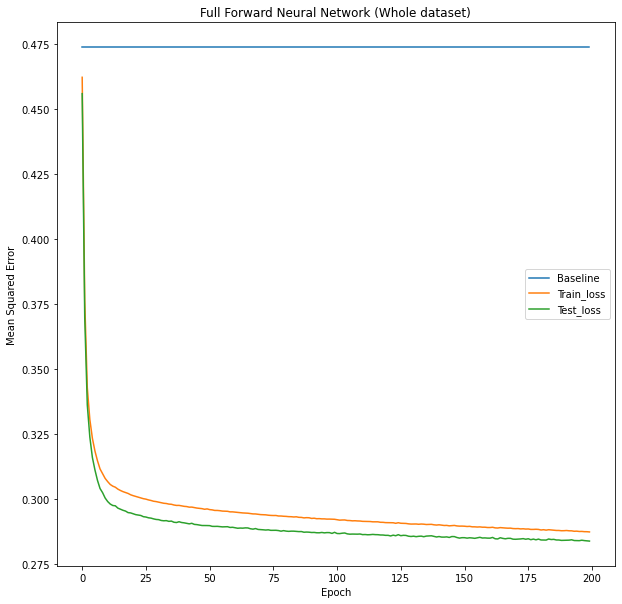

In [31]:
if train_FFN is True:

  # Show results of the loss function whole

  fig = plt.figure(figsize = (10,10))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  baseline = [np.mean(losses_train) for i in range(len(train_losses_whole))]

  ax.plot(baseline, label='Baseline')
  ax.plot([np.mean(i) for i in train_losses_whole], label= 'Train_loss')
  ax.plot([np.mean(i) for i in test_losses_whole], label= 'Test_loss')
  ax.set_title("Full Forward Neural Network (Whole dataset)")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()

In [32]:
results = torch.Tensor(1, 30, 18).to(device)
with torch.no_grad():
  trained_model_FFN_whole.train()
  count = 0
  for i in tqdm(training_data_seq):
    batch_result = torch.Tensor(1, 18).to(device)
    new = i[0].unsqueeze(0)

    for j in range(30):
      output = trained_model_FFN_whole(new)
      new = output
      if j == 0:
        batch_result = output
      else:
        batch_result = torch.cat((batch_result, output), 0)

    if count == 0:
      results = batch_result.unsqueeze(0)
    else:
      results = torch.cat((results, batch_result.unsqueeze(0)), 0)
    
    count += 1


100%|██████████| 56970/56970 [06:54<00:00, 137.33it/s]


In [33]:
print(results.shape)
print(training_target_seq.shape)


torch.Size([56970, 30, 18])
torch.Size([56970, 30, 18])


In [34]:
criterion = nn.MSELoss()

losses_train = []

for i in range(len(results)):
  output = results[i]
  target = training_target_seq[i]
  loss = criterion(output, target)
  losses_train.append(loss.item())

print("Training set")
print("Mean Loss of FFN baselinemodel: ", np.mean(losses_train))
print("Standard deviation Loss of FFN baselinemodel: ", np.std(losses_train))
print('\n')

base_line_loss = np.mean(losses_train)

Training set
Mean Loss of FFN baselinemodel:  0.5586901619624983
Standard deviation Loss of FFN baselinemodel:  0.34336845843293334




# Conclusions FFN

Training this small, easy FFN have an improvement to the base model in the case that we don't take a sequence of samples but we compare each sample individually.

# Transformer Model settings

Now, we define a class with the transformer model that we are going to use:

Using the already written pytorch library for Transformers:

1) torch.nn.TransformerEncoderLayer (https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html)

*   d_model –> the number of expected features in the input (required).
*   nhead –> the number of heads in the multiheadattention models (required).
*   dropout –> the dropout value (default=0.1).
*   activation –> the activation function of the intermediate layer, can be a string (“relu” or “gelu”) or a unary callable. (default: relu)
*   layer_norm_eps –> the eps value in layer normalization components (default=1e-5).
*   batch_first –> If True, then the input and output tensors are provided as (batch, seq, feature). (default: False)
*   norm_first –> if True, layer norm is done prior to attention and feedforward operations, respectivaly. Otherwise it’s done after. (default: False (after))

2) torch.nn.TransformerDecoderLayer

* d_model –> the number of expected features in the input (required).
* nhead –> the number of heads in the multiheadattention models (required).
* dim_feedforward –> the dimension of the feedforward network model (default=2048).
* dropout –> the dropout value (default=0.1).
* activation –> the activation function of the intermediate layer, can be a string (“relu” or “gelu”) or a unary callable. Default: relu
* layer_norm_eps –> the eps value in layer normalization components (default=1e-5).
* batch_first –> If True, then the input and output tensors are provided as (batch, seq, feature). Default: False.
* norm_first –> if True, layer norm is done prior to self attention, multihead attention and feedforward operations, respectivaly. Otherwise it’s done after. Default: False (after).

3) torch.nn.TransformerEncoder

* encoder_layer –> an instance of the TransformerEncoderLayer() class (required).
* num_layers –> the number of sub-encoder-layers in the encoder (required).
* norm –> the layer normalization component (optional).


4) torch.nn.TransformerDecoder

* decoder_layer – an instance of the TransformerDecoderLayer() class (required).
* num_layers – the number of sub-decoder-layers in the decoder (required).
* norm – the layer normalization component (optional).


In [35]:
class Transformer(nn.Module):
    def __init__(self, feature_size, output_size, num_encoder_layers, num_heads, num_decoder_layers, device, dim_feedforward: int=2048, dropout: float =0.1, batch_first: bool = False):
        super(Transformer, self).__init__()
        
        encoder_layer = nn.TransformerEncoderLayer(d_model= feature_size, nhead= num_heads, dim_feedforward=dim_feedforward, dropout=dropout, device=device, batch_first=batch_first)
        decoder_layer = nn.TransformerDecoderLayer(d_model= feature_size, nhead= num_heads, dim_feedforward=dim_feedforward, dropout=dropout, device=device, batch_first=batch_first)
        
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers= num_encoder_layers)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers= num_decoder_layers)

        self.output_size = output_size
        self.device = device

    def generate_square_mask(self, dim):
        return torch.triu(torch.ones(dim, dim) * float('-inf'), diagonal=1).to(self.device)

    def positional_encoding(seq_len: int, dim_model: int, device):

        position_encoding = torch.zeros(seq_len, dim_model)
        for pos in range(seq_len):
          for i in range(0, int(dim_model / 2)):
            position_encoding[pos, 2 * i] = math.sin(pos / (10000 ** ((2 * i)/dim_model)))
            position_encoding[pos, (2 * i) + 1] = math.cos(pos / (10000 ** ((2 * i)/dim_model)))

        return position_encoding.to(device)
        
    def forward (self, enc_input, dec_input):
        
        mask = self.generate_square_mask(len(enc_input))

        src_pos_enc = enc_input + self.positional_encoding(seq_len= enc_input.shape[1], dim_model= enc_input.shape[2], device= self.device)
        src_pos_dec = dec_input + self.positional_encoding(seq_len= dec_input.shape[1], dim_model= dec_input.shape[2], device= self.device)

        output = self.encoder (src=src_pos_enc, mask=None)
        output = self.decoder (tgt= src_pos_dec, memory= output, tgt_mask=mask, memory_mask=None)
        
        return output

We should define an optimizer too.
For this, we use the pytorch library:

* SGD –> Stochastic gradient descent.

1) torch.optim.SDG (https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)

* params (iterable) – iterable of parameters to optimize or dicts defining parameter groups
* lr (float) – learning rate
* momentum (float, optional) – momentum factor (default: 0)
* weight_decay (float, optional) – weight decay (L2 penalty) (default: 0)
* dampening (float, optional) – dampening for momentum (default: 0)
* nesterov (bool, optional) – enables Nesterov momentum (default: False)

In [36]:
def training_transformer(model, optimizer, criterion, train_loader, test_loader, n_epochs):
  epoch_loss_train = []
  epoch_loss_test = []

  for e in range(1, n_epochs + 1):

    print(f'Epoch: {e} of {n_epochs}')
    print('Training...')
    model.train()

    for i in tqdm(train_loader):

      input = i[0]
      target = i[1]

      net_out = model.forward(input, target)

      #Compute loss
      loss = criterion(net_out, target)

      optimizer.zero_grad()

      #Backpropagation
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

      #Optimization
      optimizer.step()


    print('\nTest with training set')
    losses_train = []
    model.eval()
    with torch.no_grad():
      for i in tqdm(train_loader):
        input = i[0]
        target = i[1]

        net_out = model.forward(input, target)
        #Compute loss
        losses_train.append (float(criterion(net_out, target).item()))

    
    print('\nCurrent Mean loss Train Set: ', np.mean(losses_train))
    epoch_loss_train.append(losses_train)

    print('\nTest with test set')
    losses_test = []
    model.eval()
    with torch.no_grad():
      for i in tqdm(test_loader):
        input = i[0]
        target = i[1]

        net_out = model.forward(input, target)

        #Compute loss
        losses_test.append (float(criterion(net_out, target).item()))

    print('\nCurrent Mean loss Test Set: ', np.mean(losses_test))
    epoch_loss_test.append(losses_test)

    print('\n')

  return model, epoch_loss_train, epoch_loss_test

In [37]:
# Initialize Transformer Model and Optimizer

continue_training = False

if continue_training is False:
  model_transformer = Transformer (num_encoder_layers=6,
                      num_decoder_layers=1,
                      feature_size=18,
                      output_size=18,
                      num_heads=6,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=False)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.SGD(model_transformer.parameters(), lr=0.01)
criterion = nn.MSELoss()

print('Setup optimizer Ok')


train_transformer = True

if train_transformer is True:
  trained_model_transformer, train_losses_1, test_losses_1 = training_transformer(
      model= model_transformer, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs)

Setup model Ok
Setup optimizer Ok
Epoch: 1 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.36it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.34it/s]



Current Mean loss Train Set:  0.21668729001657155

Test with test set


100%|██████████| 211/211 [00:02<00:00, 97.85it/s] 



Current Mean loss Test Set:  0.21740531193984064


Epoch: 2 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.18it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.80it/s]



Current Mean loss Train Set:  0.1897578363067982

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.44it/s]



Current Mean loss Test Set:  0.19019142082799667


Epoch: 3 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.33it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.48it/s]



Current Mean loss Train Set:  0.17256957139935603

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.96it/s]



Current Mean loss Test Set:  0.1732429128970015


Epoch: 4 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.36it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.29it/s]



Current Mean loss Train Set:  0.15900680865737374

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.33it/s]



Current Mean loss Test Set:  0.1596502147579645


Epoch: 5 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.37it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.69it/s]



Current Mean loss Train Set:  0.14865214183432232

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.00it/s]



Current Mean loss Test Set:  0.1494091809925875


Epoch: 6 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.82it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.70it/s] 



Current Mean loss Train Set:  0.14079644490992665

Test with test set


100%|██████████| 211/211 [00:02<00:00, 98.88it/s] 



Current Mean loss Test Set:  0.1413734410823239


Epoch: 7 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.92it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.64it/s] 



Current Mean loss Train Set:  0.13448980877106287

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.02it/s]



Current Mean loss Test Set:  0.13517893109276397


Epoch: 8 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.15it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.61it/s]



Current Mean loss Train Set:  0.1292670773457012

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.09it/s]



Current Mean loss Test Set:  0.12971054533081597


Epoch: 9 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.41it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 101.77it/s]



Current Mean loss Train Set:  0.1251012791672024

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.16it/s]



Current Mean loss Test Set:  0.12576772562135452


Epoch: 10 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.32it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.93it/s]



Current Mean loss Train Set:  0.12194296323732051

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.87it/s]



Current Mean loss Test Set:  0.12242970213082165


Epoch: 11 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.09it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.34it/s]



Current Mean loss Train Set:  0.11915164986226105

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.46it/s]



Current Mean loss Test Set:  0.11968554662302207


Epoch: 12 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.15it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.03it/s]



Current Mean loss Train Set:  0.11651627017501909

Test with test set


100%|██████████| 211/211 [00:02<00:00, 99.76it/s] 



Current Mean loss Test Set:  0.11703099472827821


Epoch: 13 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.04it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 101.36it/s]



Current Mean loss Train Set:  0.11453595205066454

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.84it/s]



Current Mean loss Test Set:  0.11499413526594922


Epoch: 14 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.19it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.27it/s]



Current Mean loss Train Set:  0.11281636880692085

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.09it/s]



Current Mean loss Test Set:  0.11330736156605996


Epoch: 15 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.18it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 98.91it/s]



Current Mean loss Train Set:  0.11113119542818437

Test with test set


100%|██████████| 211/211 [00:02<00:00, 98.01it/s] 



Current Mean loss Test Set:  0.11148811094639426


Epoch: 16 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.24it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.60it/s]



Current Mean loss Train Set:  0.10962340979983519

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.25it/s]



Current Mean loss Test Set:  0.1101264334967916


Epoch: 17 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.46it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 101.13it/s]



Current Mean loss Train Set:  0.10866690514949574

Test with test set


100%|██████████| 211/211 [00:02<00:00, 102.68it/s]



Current Mean loss Test Set:  0.10904608486811697


Epoch: 18 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.22it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 101.19it/s]



Current Mean loss Train Set:  0.1064383684627598

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.78it/s]



Current Mean loss Test Set:  0.10684512583847859


Epoch: 19 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.52it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 101.14it/s]



Current Mean loss Train Set:  0.10462279400036421

Test with test set


100%|██████████| 211/211 [00:02<00:00, 102.37it/s]



Current Mean loss Test Set:  0.10501155818666892


Epoch: 20 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.98it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 101.05it/s]



Current Mean loss Train Set:  0.10267531194416644

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.63it/s]



Current Mean loss Test Set:  0.10316299929579287


Epoch: 21 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.27it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 101.02it/s]



Current Mean loss Train Set:  0.1013079158443881

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.33it/s]



Current Mean loss Test Set:  0.10188684277059908


Epoch: 22 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.32it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 101.77it/s]



Current Mean loss Train Set:  0.09926479293515081

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.90it/s]



Current Mean loss Test Set:  0.09972576567488259


Epoch: 23 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.25it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.47it/s]



Current Mean loss Train Set:  0.09781664063964723

Test with test set


100%|██████████| 211/211 [00:02<00:00, 99.12it/s]



Current Mean loss Test Set:  0.09817701219735553


Epoch: 24 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.41it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.32it/s]



Current Mean loss Train Set:  0.0964567316926549

Test with test set


100%|██████████| 211/211 [00:02<00:00, 99.59it/s]



Current Mean loss Test Set:  0.09683809113375383


Epoch: 25 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.06it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.87it/s]



Current Mean loss Train Set:  0.09531196016718238

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.44it/s]



Current Mean loss Test Set:  0.09584731905240018


Epoch: 26 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.27it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 101.83it/s]



Current Mean loss Train Set:  0.09424162480887957

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.87it/s]



Current Mean loss Test Set:  0.09476207809355022


Epoch: 27 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.38it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.90it/s]



Current Mean loss Train Set:  0.0934136840855686

Test with test set


100%|██████████| 211/211 [00:02<00:00, 102.28it/s]



Current Mean loss Test Set:  0.09375375627553294


Epoch: 28 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.28it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.66it/s]



Current Mean loss Train Set:  0.09236092182006755

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.70it/s]



Current Mean loss Test Set:  0.09273590283441882


Epoch: 29 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.93it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.24it/s]



Current Mean loss Train Set:  0.09163312794833889

Test with test set


100%|██████████| 211/211 [00:02<00:00, 98.86it/s]



Current Mean loss Test Set:  0.09193718728225378


Epoch: 30 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.40it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.41it/s]



Current Mean loss Train Set:  0.09082769021282013

Test with test set


100%|██████████| 211/211 [00:02<00:00, 102.31it/s]



Current Mean loss Test Set:  0.09131997776045618


Epoch: 31 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.13it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.39it/s]



Current Mean loss Train Set:  0.09025699111695287

Test with test set


100%|██████████| 211/211 [00:03<00:00, 67.51it/s]



Current Mean loss Test Set:  0.09071228617881712


Epoch: 32 of 200
Training...


100%|██████████| 1899/1899 [00:46<00:00, 40.89it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 101.38it/s]



Current Mean loss Train Set:  0.08953699163539339

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.23it/s]



Current Mean loss Test Set:  0.08982635605462355


Epoch: 33 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.01it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.03it/s]



Current Mean loss Train Set:  0.08879705922989044

Test with test set


100%|██████████| 211/211 [00:02<00:00, 102.01it/s]



Current Mean loss Test Set:  0.08916551600347199


Epoch: 34 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.47it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.82it/s]



Current Mean loss Train Set:  0.08844880454669883

Test with test set


100%|██████████| 211/211 [00:02<00:00, 102.05it/s]



Current Mean loss Test Set:  0.08881822214307378


Epoch: 35 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.40it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.84it/s]



Current Mean loss Train Set:  0.08822759838403056

Test with test set


100%|██████████| 211/211 [00:02<00:00, 102.99it/s]



Current Mean loss Test Set:  0.08862522308012885


Epoch: 36 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.18it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.51it/s]



Current Mean loss Train Set:  0.08745331724830023

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.45it/s]



Current Mean loss Test Set:  0.08786712682218913


Epoch: 37 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.84it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 101.23it/s]



Current Mean loss Train Set:  0.08712846706530619

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.54it/s]



Current Mean loss Test Set:  0.08761374474066129


Epoch: 38 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.91it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.27it/s]



Current Mean loss Train Set:  0.08664743424544778

Test with test set


100%|██████████| 211/211 [00:02<00:00, 99.18it/s] 



Current Mean loss Test Set:  0.08703769404458774


Epoch: 39 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.74it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 101.15it/s]



Current Mean loss Train Set:  0.08620718806362139

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.71it/s]



Current Mean loss Test Set:  0.08668272177825607


Epoch: 40 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.08it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 101.05it/s]



Current Mean loss Train Set:  0.08590389545487065

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.80it/s]



Current Mean loss Test Set:  0.08634774205032118


Epoch: 41 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.18it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 101.92it/s]



Current Mean loss Train Set:  0.08540819774039989

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.73it/s]



Current Mean loss Test Set:  0.08568930534107425


Epoch: 42 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.22it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 99.95it/s]



Current Mean loss Train Set:  0.08530448455208536

Test with test set


100%|██████████| 211/211 [00:02<00:00, 99.64it/s] 



Current Mean loss Test Set:  0.0855118270027694


Epoch: 43 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.22it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 101.79it/s]



Current Mean loss Train Set:  0.08479112309608226

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.10it/s]



Current Mean loss Test Set:  0.0851469640024183


Epoch: 44 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.05it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.69it/s]



Current Mean loss Train Set:  0.08468261029396702

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.06it/s]



Current Mean loss Test Set:  0.08512625375418302


Epoch: 45 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.35it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 101.07it/s]



Current Mean loss Train Set:  0.08415434626826115

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.31it/s]



Current Mean loss Test Set:  0.08445937922709926


Epoch: 46 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.04it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.28it/s]



Current Mean loss Train Set:  0.08377757031331255

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.86it/s]



Current Mean loss Test Set:  0.08436747243124727


Epoch: 47 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.36it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.60it/s]



Current Mean loss Train Set:  0.08325244503006488

Test with test set


100%|██████████| 211/211 [00:02<00:00, 99.42it/s] 



Current Mean loss Test Set:  0.08361829640741032


Epoch: 48 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.06it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.66it/s] 



Current Mean loss Train Set:  0.08325527282358157

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.14it/s]



Current Mean loss Test Set:  0.08362978594421776


Epoch: 49 of 200
Training...


100%|██████████| 1899/1899 [00:46<00:00, 41.15it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 95.73it/s]



Current Mean loss Train Set:  0.08304823072074966

Test with test set


100%|██████████| 211/211 [00:02<00:00, 99.91it/s]



Current Mean loss Test Set:  0.08329289429490035


Epoch: 50 of 200
Training...


100%|██████████| 1899/1899 [00:46<00:00, 40.50it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 101.01it/s]



Current Mean loss Train Set:  0.08296682655795616

Test with test set


100%|██████████| 211/211 [00:02<00:00, 99.73it/s] 



Current Mean loss Test Set:  0.08339232469410128


Epoch: 51 of 200
Training...


100%|██████████| 1899/1899 [00:46<00:00, 41.14it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.69it/s]



Current Mean loss Train Set:  0.08244053134719218

Test with test set


100%|██████████| 211/211 [00:02<00:00, 99.63it/s] 



Current Mean loss Test Set:  0.08281645660787397


Epoch: 52 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.12it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.42it/s]



Current Mean loss Train Set:  0.08223599650401263

Test with test set


100%|██████████| 211/211 [00:02<00:00, 99.79it/s] 



Current Mean loss Test Set:  0.0826369892117254


Epoch: 53 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.39it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 101.22it/s]



Current Mean loss Train Set:  0.08188287302922298

Test with test set


100%|██████████| 211/211 [00:02<00:00, 99.25it/s] 



Current Mean loss Test Set:  0.0821636558038081


Epoch: 54 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.10it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.68it/s]



Current Mean loss Train Set:  0.08165272420224169

Test with test set


100%|██████████| 211/211 [00:02<00:00, 102.25it/s]



Current Mean loss Test Set:  0.08202810906827167


Epoch: 55 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.74it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.43it/s]



Current Mean loss Train Set:  0.08148553056064689

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.33it/s]



Current Mean loss Test Set:  0.0818140885099698


Epoch: 56 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.23it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.66it/s]



Current Mean loss Train Set:  0.08162051070679671

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.40it/s]



Current Mean loss Test Set:  0.08188313108061163


Epoch: 57 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.36it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 101.31it/s]



Current Mean loss Train Set:  0.08097587499557639

Test with test set


100%|██████████| 211/211 [00:02<00:00, 98.77it/s] 



Current Mean loss Test Set:  0.0812442458424523


Epoch: 58 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.26it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.79it/s]



Current Mean loss Train Set:  0.08095499353700088

Test with test set


100%|██████████| 211/211 [00:02<00:00, 102.71it/s]



Current Mean loss Test Set:  0.08142057634996012


Epoch: 59 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.52it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 101.88it/s]



Current Mean loss Train Set:  0.08058130178500503

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.51it/s]



Current Mean loss Test Set:  0.08086799641285462


Epoch: 60 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.21it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.68it/s]



Current Mean loss Train Set:  0.08060018753749625

Test with test set


100%|██████████| 211/211 [00:02<00:00, 98.38it/s]



Current Mean loss Test Set:  0.0809812167950716


Epoch: 61 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.20it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.95it/s]



Current Mean loss Train Set:  0.08036148411198753

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.45it/s]



Current Mean loss Test Set:  0.08079973195118927


Epoch: 62 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.36it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.38it/s]



Current Mean loss Train Set:  0.08009231325754873

Test with test set


100%|██████████| 211/211 [00:02<00:00, 99.15it/s]



Current Mean loss Test Set:  0.08039922028850605


Epoch: 63 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.37it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.47it/s]



Current Mean loss Train Set:  0.07954062305277056

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.16it/s]



Current Mean loss Test Set:  0.07994981231918268


Epoch: 64 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.44it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.86it/s]



Current Mean loss Train Set:  0.08002464287669613

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.12it/s]



Current Mean loss Test Set:  0.08042410152006488


Epoch: 65 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.38it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.93it/s]



Current Mean loss Train Set:  0.079434505063038

Test with test set


100%|██████████| 211/211 [00:02<00:00, 99.83it/s] 



Current Mean loss Test Set:  0.07974848684400179


Epoch: 66 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.14it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.78it/s]



Current Mean loss Train Set:  0.07939337565906428

Test with test set


100%|██████████| 211/211 [00:02<00:00, 102.03it/s]



Current Mean loss Test Set:  0.0798085605752129


Epoch: 67 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.38it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.75it/s]



Current Mean loss Train Set:  0.07912440215084916

Test with test set


100%|██████████| 211/211 [00:02<00:00, 102.22it/s]



Current Mean loss Test Set:  0.07940805051917148


Epoch: 68 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.28it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.75it/s]



Current Mean loss Train Set:  0.07897276401307911

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.30it/s]



Current Mean loss Test Set:  0.07936980326381905


Epoch: 69 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.45it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 101.42it/s]



Current Mean loss Train Set:  0.07877430779807439

Test with test set


100%|██████████| 211/211 [00:02<00:00, 103.49it/s]



Current Mean loss Test Set:  0.07908447741826563


Epoch: 70 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.42it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 101.27it/s]



Current Mean loss Train Set:  0.07841552034012578

Test with test set


100%|██████████| 211/211 [00:02<00:00, 99.96it/s]



Current Mean loss Test Set:  0.07870415799425677


Epoch: 71 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.22it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 101.17it/s]



Current Mean loss Train Set:  0.07825109807714592

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.81it/s]



Current Mean loss Test Set:  0.07868918202711507


Epoch: 72 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.18it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.67it/s]



Current Mean loss Train Set:  0.07821158077440304

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.69it/s]



Current Mean loss Test Set:  0.07860948634444255


Epoch: 73 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.13it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.83it/s]



Current Mean loss Train Set:  0.07782240625688627

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.42it/s]



Current Mean loss Test Set:  0.07815452749836502


Epoch: 74 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.99it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.27it/s]



Current Mean loss Train Set:  0.0776387688680785

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.76it/s]



Current Mean loss Test Set:  0.07804392181089705


Epoch: 75 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.44it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.53it/s]



Current Mean loss Train Set:  0.07743800036597402

Test with test set


100%|██████████| 211/211 [00:02<00:00, 98.91it/s]



Current Mean loss Test Set:  0.07791357849375896


Epoch: 76 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.07it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.51it/s]



Current Mean loss Train Set:  0.0776963279518314

Test with test set


100%|██████████| 211/211 [00:02<00:00, 99.50it/s] 



Current Mean loss Test Set:  0.0780936341150112


Epoch: 77 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.23it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.32it/s]



Current Mean loss Train Set:  0.0771109418646325

Test with test set


100%|██████████| 211/211 [00:02<00:00, 98.70it/s] 



Current Mean loss Test Set:  0.0773353128212888


Epoch: 78 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.19it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.13it/s]



Current Mean loss Train Set:  0.07701877540878838

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.42it/s]



Current Mean loss Test Set:  0.07746197775853754


Epoch: 79 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.93it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 101.05it/s]



Current Mean loss Train Set:  0.07705139386035569

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.88it/s]



Current Mean loss Test Set:  0.07749480563458673


Epoch: 80 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.48it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.19it/s]



Current Mean loss Train Set:  0.07679174524026208

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.00it/s]



Current Mean loss Test Set:  0.07711078360747387


Epoch: 81 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.91it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.89it/s]



Current Mean loss Train Set:  0.07651384108321738

Test with test set


100%|██████████| 211/211 [00:02<00:00, 102.40it/s]



Current Mean loss Test Set:  0.07683073155476018


Epoch: 82 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.41it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.62it/s]



Current Mean loss Train Set:  0.07634025818818867

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.82it/s]



Current Mean loss Test Set:  0.07672483763564819


Epoch: 83 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.10it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.01it/s]



Current Mean loss Train Set:  0.07576627335489079

Test with test set


100%|██████████| 211/211 [00:02<00:00, 102.17it/s]



Current Mean loss Test Set:  0.07619633599762668


Epoch: 84 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.32it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.75it/s]



Current Mean loss Train Set:  0.07617370918463756

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.59it/s]



Current Mean loss Test Set:  0.0765855473541253


Epoch: 85 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.18it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.87it/s]



Current Mean loss Train Set:  0.0760120491783138

Test with test set


100%|██████████| 211/211 [00:02<00:00, 98.27it/s] 



Current Mean loss Test Set:  0.07655196349132118


Epoch: 86 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.05it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.80it/s]



Current Mean loss Train Set:  0.07557651989275747

Test with test set


100%|██████████| 211/211 [00:02<00:00, 99.73it/s] 



Current Mean loss Test Set:  0.0760780480023809


Epoch: 87 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.96it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 101.24it/s]



Current Mean loss Train Set:  0.0754643290344353

Test with test set


100%|██████████| 211/211 [00:02<00:00, 98.26it/s] 



Current Mean loss Test Set:  0.07574957605645555


Epoch: 88 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.86it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.22it/s]



Current Mean loss Train Set:  0.07512175569751188

Test with test set


100%|██████████| 211/211 [00:02<00:00, 98.65it/s]



Current Mean loss Test Set:  0.07540359535205986


Epoch: 89 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.18it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 101.09it/s]



Current Mean loss Train Set:  0.07524728018588427

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.74it/s]



Current Mean loss Test Set:  0.07576078430736234


Epoch: 90 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.23it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 101.69it/s]



Current Mean loss Train Set:  0.07508293107709112

Test with test set


100%|██████████| 211/211 [00:02<00:00, 99.36it/s]



Current Mean loss Test Set:  0.07545038432730318


Epoch: 91 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.03it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 101.08it/s]



Current Mean loss Train Set:  0.07482329120426946

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.21it/s]



Current Mean loss Test Set:  0.07515840352429033


Epoch: 92 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.26it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 101.09it/s]



Current Mean loss Train Set:  0.07473499651972779

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.00it/s]



Current Mean loss Test Set:  0.07521882060014806


Epoch: 93 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.95it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.52it/s]



Current Mean loss Train Set:  0.07455154079718299

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.67it/s]



Current Mean loss Test Set:  0.07485676256683765


Epoch: 94 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.07it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.61it/s] 



Current Mean loss Train Set:  0.07452879803134554

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.27it/s]



Current Mean loss Test Set:  0.07496343722558134


Epoch: 95 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.39it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.59it/s] 



Current Mean loss Train Set:  0.07400685201755569

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.56it/s]



Current Mean loss Test Set:  0.07437133962085461


Epoch: 96 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.40it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.98it/s]



Current Mean loss Train Set:  0.07391991148486522

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.72it/s]



Current Mean loss Test Set:  0.07440456488474285


Epoch: 97 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.00it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.60it/s]



Current Mean loss Train Set:  0.0739035223948604

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.99it/s]



Current Mean loss Test Set:  0.07423362826213452


Epoch: 98 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.30it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 101.70it/s]



Current Mean loss Train Set:  0.07366303439051494

Test with test set


100%|██████████| 211/211 [00:02<00:00, 98.52it/s] 



Current Mean loss Test Set:  0.0740832311600023


Epoch: 99 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.20it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.05it/s]



Current Mean loss Train Set:  0.07375401602749011

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.28it/s]



Current Mean loss Test Set:  0.07414225547163972


Epoch: 100 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.85it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 101.40it/s]



Current Mean loss Train Set:  0.07354171281624557

Test with test set


100%|██████████| 211/211 [00:02<00:00, 96.65it/s]



Current Mean loss Test Set:  0.07380707305966396


Epoch: 101 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.18it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.71it/s]



Current Mean loss Train Set:  0.0735600112205182

Test with test set


100%|██████████| 211/211 [00:02<00:00, 95.80it/s]



Current Mean loss Test Set:  0.07405682278894135


Epoch: 102 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.29it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.70it/s]



Current Mean loss Train Set:  0.07353937327312507

Test with test set


100%|██████████| 211/211 [00:02<00:00, 97.01it/s]



Current Mean loss Test Set:  0.07378985519163417


Epoch: 103 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.00it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.51it/s]



Current Mean loss Train Set:  0.07329211957662465

Test with test set


100%|██████████| 211/211 [00:02<00:00, 102.03it/s]



Current Mean loss Test Set:  0.07364880616701609


Epoch: 104 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.14it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.97it/s]



Current Mean loss Train Set:  0.07302839660319672

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.38it/s]



Current Mean loss Test Set:  0.07342372326206822


Epoch: 105 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.02it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.78it/s]



Current Mean loss Train Set:  0.07336173720340028

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.26it/s]



Current Mean loss Test Set:  0.07382178797399828


Epoch: 106 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.39it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.22it/s]



Current Mean loss Train Set:  0.07292112886018977

Test with test set


100%|██████████| 211/211 [00:02<00:00, 96.13it/s] 



Current Mean loss Test Set:  0.07332033958833364


Epoch: 107 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.48it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.59it/s]



Current Mean loss Train Set:  0.07259118127361482

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.33it/s]



Current Mean loss Test Set:  0.07292928926258291


Epoch: 108 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.17it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.17it/s]



Current Mean loss Train Set:  0.07274826403006934

Test with test set


100%|██████████| 211/211 [00:02<00:00, 99.02it/s]



Current Mean loss Test Set:  0.07311727145413087


Epoch: 109 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.19it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.89it/s] 



Current Mean loss Train Set:  0.07242628130247682

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.69it/s]



Current Mean loss Test Set:  0.07268125802207898


Epoch: 110 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.18it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.34it/s]



Current Mean loss Train Set:  0.0722142460139536

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.10it/s]



Current Mean loss Test Set:  0.0726217567143847


Epoch: 111 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.28it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.55it/s]



Current Mean loss Train Set:  0.07260700689335445

Test with test set


100%|██████████| 211/211 [00:02<00:00, 98.67it/s]



Current Mean loss Test Set:  0.07295696426765613


Epoch: 112 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.14it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.80it/s]



Current Mean loss Train Set:  0.071728359870593

Test with test set


100%|██████████| 211/211 [00:02<00:00, 98.01it/s]



Current Mean loss Test Set:  0.07215642413539344


Epoch: 113 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.34it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.84it/s] 



Current Mean loss Train Set:  0.07196087058655144

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.68it/s]



Current Mean loss Test Set:  0.07220510788862174


Epoch: 114 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.08it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.48it/s]



Current Mean loss Train Set:  0.07190208090150463

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.15it/s]



Current Mean loss Test Set:  0.07225426918522442


Epoch: 115 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.02it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 101.11it/s]



Current Mean loss Train Set:  0.07159680119269832

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.37it/s]



Current Mean loss Test Set:  0.0718973259931492


Epoch: 116 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.01it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.59it/s]



Current Mean loss Train Set:  0.07145167556466273

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.28it/s]



Current Mean loss Test Set:  0.07186626171543135


Epoch: 117 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.40it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.28it/s]



Current Mean loss Train Set:  0.0713092363240877

Test with test set


100%|██████████| 211/211 [00:02<00:00, 103.08it/s]



Current Mean loss Test Set:  0.07167412112886307


Epoch: 118 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.27it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.38it/s]



Current Mean loss Train Set:  0.07136141385229842

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.13it/s]



Current Mean loss Test Set:  0.0717587409920602


Epoch: 119 of 200
Training...


100%|██████████| 1899/1899 [00:48<00:00, 38.98it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.04it/s]



Current Mean loss Train Set:  0.07125088922079141

Test with test set


100%|██████████| 211/211 [00:02<00:00, 99.51it/s]



Current Mean loss Test Set:  0.07164444036393369


Epoch: 120 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.95it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.89it/s]



Current Mean loss Train Set:  0.0711983080998479

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.83it/s]



Current Mean loss Test Set:  0.07169559061244765


Epoch: 121 of 200
Training...


100%|██████████| 1899/1899 [00:46<00:00, 41.25it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.98it/s]



Current Mean loss Train Set:  0.07121108688724047

Test with test set


100%|██████████| 211/211 [00:02<00:00, 98.97it/s]



Current Mean loss Test Set:  0.07172339305422883


Epoch: 122 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.98it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.79it/s]



Current Mean loss Train Set:  0.07123213628402128

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.26it/s]



Current Mean loss Test Set:  0.07167495875420729


Epoch: 123 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.07it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.47it/s] 



Current Mean loss Train Set:  0.07078204674154849

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.91it/s]



Current Mean loss Test Set:  0.07100557970209709


Epoch: 124 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.93it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.50it/s]



Current Mean loss Train Set:  0.07044373724360475

Test with test set


100%|██████████| 211/211 [00:02<00:00, 98.76it/s] 



Current Mean loss Test Set:  0.07088489484448003


Epoch: 125 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.78it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.11it/s] 



Current Mean loss Train Set:  0.07085085695530001

Test with test set


100%|██████████| 211/211 [00:02<00:00, 99.47it/s]



Current Mean loss Test Set:  0.07127567684339686


Epoch: 126 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.78it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.88it/s]



Current Mean loss Train Set:  0.0704186435488728

Test with test set


100%|██████████| 211/211 [00:02<00:00, 98.94it/s]



Current Mean loss Test Set:  0.07082785976724038


Epoch: 127 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.52it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.81it/s]



Current Mean loss Train Set:  0.07067200222325802

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.42it/s]



Current Mean loss Test Set:  0.0711534209196319


Epoch: 128 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.28it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.90it/s]



Current Mean loss Train Set:  0.07050042450938054

Test with test set


100%|██████████| 211/211 [00:02<00:00, 103.51it/s]



Current Mean loss Test Set:  0.07086792000308986


Epoch: 129 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.17it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 101.13it/s]



Current Mean loss Train Set:  0.07031375818688221

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.43it/s]



Current Mean loss Test Set:  0.07082903831844081


Epoch: 130 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.17it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.57it/s]



Current Mean loss Train Set:  0.07040390327941624

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.10it/s]



Current Mean loss Test Set:  0.07082407464277687


Epoch: 131 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.83it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.41it/s]



Current Mean loss Train Set:  0.07029714196794845

Test with test set


100%|██████████| 211/211 [00:02<00:00, 99.25it/s] 



Current Mean loss Test Set:  0.07060418159687688


Epoch: 132 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.13it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.49it/s]



Current Mean loss Train Set:  0.07017765588089314

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.37it/s]



Current Mean loss Test Set:  0.07072813143309259


Epoch: 133 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.05it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.06it/s]



Current Mean loss Train Set:  0.06974242444593007

Test with test set


100%|██████████| 211/211 [00:02<00:00, 97.55it/s]



Current Mean loss Test Set:  0.0700843665589936


Epoch: 134 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.16it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.68it/s]



Current Mean loss Train Set:  0.07009736670984476

Test with test set


100%|██████████| 211/211 [00:02<00:00, 99.25it/s]



Current Mean loss Test Set:  0.07040905489882021


Epoch: 135 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.05it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.34it/s]



Current Mean loss Train Set:  0.06974352261992177

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.18it/s]



Current Mean loss Test Set:  0.0701935472787839


Epoch: 136 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.35it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.37it/s]



Current Mean loss Train Set:  0.06977963852468072

Test with test set


100%|██████████| 211/211 [00:02<00:00, 102.24it/s]



Current Mean loss Test Set:  0.07018852911854243


Epoch: 137 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.80it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.46it/s]



Current Mean loss Train Set:  0.0698796071743827

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.42it/s]



Current Mean loss Test Set:  0.07026902688623039


Epoch: 138 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.22it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.36it/s]



Current Mean loss Train Set:  0.06959722304188025

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.49it/s]



Current Mean loss Test Set:  0.07005085928533314


Epoch: 139 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.33it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.83it/s] 



Current Mean loss Train Set:  0.06952843857853584

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.74it/s]



Current Mean loss Test Set:  0.06984027558099037


Epoch: 140 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.15it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.39it/s]



Current Mean loss Train Set:  0.06964130746911801

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.83it/s]



Current Mean loss Test Set:  0.07020366785085597


Epoch: 141 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.43it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.66it/s]



Current Mean loss Train Set:  0.06951344493244936

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.24it/s]



Current Mean loss Test Set:  0.06976490134099649


Epoch: 142 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.08it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 96.52it/s] 



Current Mean loss Train Set:  0.06921162934931659

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.39it/s]



Current Mean loss Test Set:  0.06948373071249063


Epoch: 143 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.03it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.58it/s]



Current Mean loss Train Set:  0.06940652808275519

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.43it/s]



Current Mean loss Test Set:  0.06977510199798227


Epoch: 144 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.39it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.95it/s]



Current Mean loss Train Set:  0.06925629110336931

Test with test set


100%|██████████| 211/211 [00:02<00:00, 98.71it/s] 



Current Mean loss Test Set:  0.069559693301176


Epoch: 145 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.03it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.89it/s]



Current Mean loss Train Set:  0.06896976510228578

Test with test set


100%|██████████| 211/211 [00:02<00:00, 96.17it/s]



Current Mean loss Test Set:  0.06930207574113285


Epoch: 146 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.45it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 95.18it/s] 



Current Mean loss Train Set:  0.06943590165738246

Test with test set


100%|██████████| 211/211 [00:02<00:00, 102.15it/s]



Current Mean loss Test Set:  0.06993389240867719


Epoch: 147 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.31it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.32it/s] 



Current Mean loss Train Set:  0.06882180854003325

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.53it/s]



Current Mean loss Test Set:  0.06914952097204624


Epoch: 148 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.91it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 98.16it/s]



Current Mean loss Train Set:  0.06888660510757712

Test with test set


100%|██████████| 211/211 [00:02<00:00, 99.58it/s]



Current Mean loss Test Set:  0.06923161913150859


Epoch: 149 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.07it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.57it/s] 



Current Mean loss Train Set:  0.06853888640910968

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.92it/s]



Current Mean loss Test Set:  0.06890745196156027


Epoch: 150 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.45it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.28it/s]



Current Mean loss Train Set:  0.06883674049225212

Test with test set


100%|██████████| 211/211 [00:02<00:00, 97.70it/s]



Current Mean loss Test Set:  0.06925444073657289


Epoch: 151 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.77it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 98.51it/s] 



Current Mean loss Train Set:  0.06858969412904906

Test with test set


100%|██████████| 211/211 [00:02<00:00, 96.70it/s]



Current Mean loss Test Set:  0.06908678153962321


Epoch: 152 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.12it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.56it/s]



Current Mean loss Train Set:  0.06879856631850305

Test with test set


100%|██████████| 211/211 [00:02<00:00, 97.59it/s]



Current Mean loss Test Set:  0.06908818032433636


Epoch: 153 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.86it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 98.48it/s]



Current Mean loss Train Set:  0.0685405796673296

Test with test set


100%|██████████| 211/211 [00:02<00:00, 97.48it/s]



Current Mean loss Test Set:  0.06891889010348591


Epoch: 154 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.95it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.67it/s] 



Current Mean loss Train Set:  0.06853130916079576

Test with test set


100%|██████████| 211/211 [00:02<00:00, 98.21it/s]



Current Mean loss Test Set:  0.0687925842595044


Epoch: 155 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.47it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.59it/s]



Current Mean loss Train Set:  0.06839026902861631

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.01it/s]



Current Mean loss Test Set:  0.06874564056995355


Epoch: 156 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.62it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.14it/s] 



Current Mean loss Train Set:  0.06849205439783762

Test with test set


100%|██████████| 211/211 [00:02<00:00, 97.91it/s] 



Current Mean loss Test Set:  0.0688736340763727


Epoch: 157 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.04it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.39it/s]



Current Mean loss Train Set:  0.06844310633536073

Test with test set


100%|██████████| 211/211 [00:02<00:00, 97.09it/s]



Current Mean loss Test Set:  0.06879401219328998


Epoch: 158 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.08it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.90it/s]



Current Mean loss Train Set:  0.06850818909700762

Test with test set


100%|██████████| 211/211 [00:02<00:00, 96.71it/s] 



Current Mean loss Test Set:  0.06887019185517071


Epoch: 159 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.77it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 98.73it/s]



Current Mean loss Train Set:  0.06794153212551508

Test with test set


100%|██████████| 211/211 [00:02<00:00, 98.82it/s]



Current Mean loss Test Set:  0.06825920596930653


Epoch: 160 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.63it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 98.55it/s]



Current Mean loss Train Set:  0.06790930991418553

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.02it/s]



Current Mean loss Test Set:  0.06834050449785463


Epoch: 161 of 200
Training...


100%|██████████| 1899/1899 [00:46<00:00, 41.25it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 98.90it/s] 



Current Mean loss Train Set:  0.06796832196022129

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.79it/s]



Current Mean loss Test Set:  0.06838170377210984


Epoch: 162 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.56it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 97.87it/s] 



Current Mean loss Train Set:  0.0680196651067779

Test with test set


100%|██████████| 211/211 [00:02<00:00, 99.34it/s] 



Current Mean loss Test Set:  0.06841129170492362


Epoch: 163 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.72it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.24it/s]



Current Mean loss Train Set:  0.06818592017335036

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.45it/s]



Current Mean loss Test Set:  0.06855902573649918


Epoch: 164 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.89it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 98.18it/s] 



Current Mean loss Train Set:  0.06755077910696348

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.44it/s]



Current Mean loss Test Set:  0.06789568511513172


Epoch: 165 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.95it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 98.73it/s] 



Current Mean loss Train Set:  0.06801693832963752

Test with test set


100%|██████████| 211/211 [00:02<00:00, 102.11it/s]



Current Mean loss Test Set:  0.06845561813086412


Epoch: 166 of 200
Training...


100%|██████████| 1899/1899 [00:46<00:00, 40.74it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.07it/s]



Current Mean loss Train Set:  0.06815627686534197

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.65it/s]



Current Mean loss Test Set:  0.06843556869792712


Epoch: 167 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.61it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 98.36it/s] 



Current Mean loss Train Set:  0.06821598562795969

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.53it/s]



Current Mean loss Test Set:  0.0685044435951947


Epoch: 168 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.76it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 98.18it/s]



Current Mean loss Train Set:  0.06795020754193556

Test with test set


100%|██████████| 211/211 [00:02<00:00, 99.28it/s] 



Current Mean loss Test Set:  0.0682333926559907


Epoch: 169 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.12it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 98.21it/s] 



Current Mean loss Train Set:  0.0673267025227858

Test with test set


100%|██████████| 211/211 [00:02<00:00, 94.87it/s]



Current Mean loss Test Set:  0.06767414436097394


Epoch: 170 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.64it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.12it/s] 



Current Mean loss Train Set:  0.0676024783051535

Test with test set


100%|██████████| 211/211 [00:02<00:00, 98.72it/s] 



Current Mean loss Test Set:  0.06796172183554319


Epoch: 171 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.67it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 99.96it/s] 



Current Mean loss Train Set:  0.06763228775443939

Test with test set


100%|██████████| 211/211 [00:02<00:00, 95.70it/s] 



Current Mean loss Test Set:  0.06799891990084218


Epoch: 172 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.14it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.87it/s] 



Current Mean loss Train Set:  0.06741059445660795

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.20it/s]



Current Mean loss Test Set:  0.06787471490872415


Epoch: 173 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.92it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.45it/s]



Current Mean loss Train Set:  0.06728078172065949

Test with test set


100%|██████████| 211/211 [00:02<00:00, 99.18it/s]



Current Mean loss Test Set:  0.06762359181851572


Epoch: 174 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.01it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.66it/s] 



Current Mean loss Train Set:  0.0673465465988499

Test with test set


100%|██████████| 211/211 [00:02<00:00, 99.61it/s]



Current Mean loss Test Set:  0.06771774316356645


Epoch: 175 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.83it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.40it/s]



Current Mean loss Train Set:  0.0672677673307248

Test with test set


100%|██████████| 211/211 [00:02<00:00, 99.04it/s]



Current Mean loss Test Set:  0.06765083073510378


Epoch: 176 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.80it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.45it/s]



Current Mean loss Train Set:  0.06726841297610739

Test with test set


100%|██████████| 211/211 [00:02<00:00, 99.03it/s] 



Current Mean loss Test Set:  0.06759579688028136


Epoch: 177 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.99it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 101.09it/s]



Current Mean loss Train Set:  0.06677912123473836

Test with test set


100%|██████████| 211/211 [00:02<00:00, 98.55it/s] 



Current Mean loss Test Set:  0.06710300908834449


Epoch: 178 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.79it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 98.63it/s] 



Current Mean loss Train Set:  0.06720831247145656

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.52it/s]



Current Mean loss Test Set:  0.06743452570873414


Epoch: 179 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.78it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.71it/s] 



Current Mean loss Train Set:  0.06678115121192402

Test with test set


100%|██████████| 211/211 [00:02<00:00, 103.10it/s]



Current Mean loss Test Set:  0.06710192179792865


Epoch: 180 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.07it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.73it/s] 



Current Mean loss Train Set:  0.06711594983464546

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.48it/s]



Current Mean loss Test Set:  0.06743344752850691


Epoch: 181 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.24it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.04it/s] 



Current Mean loss Train Set:  0.0667894055391061

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.70it/s]



Current Mean loss Test Set:  0.06706250338899016


Epoch: 182 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.09it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.14it/s]



Current Mean loss Train Set:  0.0667456723631935

Test with test set


100%|██████████| 211/211 [00:02<00:00, 95.54it/s] 



Current Mean loss Test Set:  0.06705660240556957


Epoch: 183 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.98it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 101.37it/s]



Current Mean loss Train Set:  0.06731583842475079

Test with test set


100%|██████████| 211/211 [00:02<00:00, 99.69it/s]



Current Mean loss Test Set:  0.06756914311675664


Epoch: 184 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.13it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.84it/s]



Current Mean loss Train Set:  0.0671376362756844

Test with test set


100%|██████████| 211/211 [00:02<00:00, 97.82it/s]



Current Mean loss Test Set:  0.06758080143922877


Epoch: 185 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.77it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.51it/s]



Current Mean loss Train Set:  0.06664837373243061

Test with test set


100%|██████████| 211/211 [00:02<00:00, 97.45it/s]



Current Mean loss Test Set:  0.06691932461061184


Epoch: 186 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.03it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.27it/s]



Current Mean loss Train Set:  0.06683678757703386

Test with test set


100%|██████████| 211/211 [00:02<00:00, 99.44it/s] 



Current Mean loss Test Set:  0.0671559499126475


Epoch: 187 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.98it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 97.15it/s] 



Current Mean loss Train Set:  0.06671988751038932

Test with test set


100%|██████████| 211/211 [00:02<00:00, 99.90it/s] 



Current Mean loss Test Set:  0.06705922287363576


Epoch: 188 of 200
Training...


100%|██████████| 1899/1899 [00:46<00:00, 40.82it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.34it/s]



Current Mean loss Train Set:  0.06657111472506597

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.56it/s]



Current Mean loss Test Set:  0.0669357023285746


Epoch: 189 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.94it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.25it/s]



Current Mean loss Train Set:  0.06666232522708482

Test with test set


100%|██████████| 211/211 [00:02<00:00, 95.45it/s]



Current Mean loss Test Set:  0.06691255249188975


Epoch: 190 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.94it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.16it/s] 



Current Mean loss Train Set:  0.06657666892495955

Test with test set


100%|██████████| 211/211 [00:02<00:00, 97.64it/s]



Current Mean loss Test Set:  0.06690305531448662


Epoch: 191 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.12it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.44it/s] 



Current Mean loss Train Set:  0.06674538919993486

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.28it/s]



Current Mean loss Test Set:  0.0670144057245616


Epoch: 192 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.54it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.09it/s]



Current Mean loss Train Set:  0.06645610060478085

Test with test set


100%|██████████| 211/211 [00:02<00:00, 97.08it/s]



Current Mean loss Test Set:  0.06692132164869828


Epoch: 193 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.61it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.18it/s]



Current Mean loss Train Set:  0.06648796878798251

Test with test set


100%|██████████| 211/211 [00:02<00:00, 99.95it/s] 



Current Mean loss Test Set:  0.06688068203310266


Epoch: 194 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.75it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.80it/s] 



Current Mean loss Train Set:  0.06647024329765462

Test with test set


100%|██████████| 211/211 [00:02<00:00, 97.80it/s] 



Current Mean loss Test Set:  0.06672967756740855


Epoch: 195 of 200
Training...


100%|██████████| 1899/1899 [00:46<00:00, 40.97it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 97.81it/s]



Current Mean loss Train Set:  0.06654626937321201

Test with test set


100%|██████████| 211/211 [00:02<00:00, 99.69it/s] 



Current Mean loss Test Set:  0.0667718506254856


Epoch: 196 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.28it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 97.93it/s]



Current Mean loss Train Set:  0.0663087329287288

Test with test set


100%|██████████| 211/211 [00:02<00:00, 99.86it/s] 



Current Mean loss Test Set:  0.06666705812111286


Epoch: 197 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 41.57it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 97.82it/s]



Current Mean loss Train Set:  0.06594189994229399

Test with test set


100%|██████████| 211/211 [00:02<00:00, 99.01it/s] 



Current Mean loss Test Set:  0.06631183422995969


Epoch: 198 of 200
Training...


100%|██████████| 1899/1899 [00:46<00:00, 41.21it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.76it/s] 



Current Mean loss Train Set:  0.0663733739619697

Test with test set


100%|██████████| 211/211 [00:02<00:00, 98.74it/s]



Current Mean loss Test Set:  0.06679525236947842


Epoch: 199 of 200
Training...


100%|██████████| 1899/1899 [00:44<00:00, 42.30it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.08it/s]



Current Mean loss Train Set:  0.0660193860982047

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.45it/s]



Current Mean loss Test Set:  0.06631753976805516


Epoch: 200 of 200
Training...


100%|██████████| 1899/1899 [00:45<00:00, 42.09it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.14it/s]



Current Mean loss Train Set:  0.06609258245776803

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.08it/s]


Current Mean loss Test Set:  0.06647929040741582




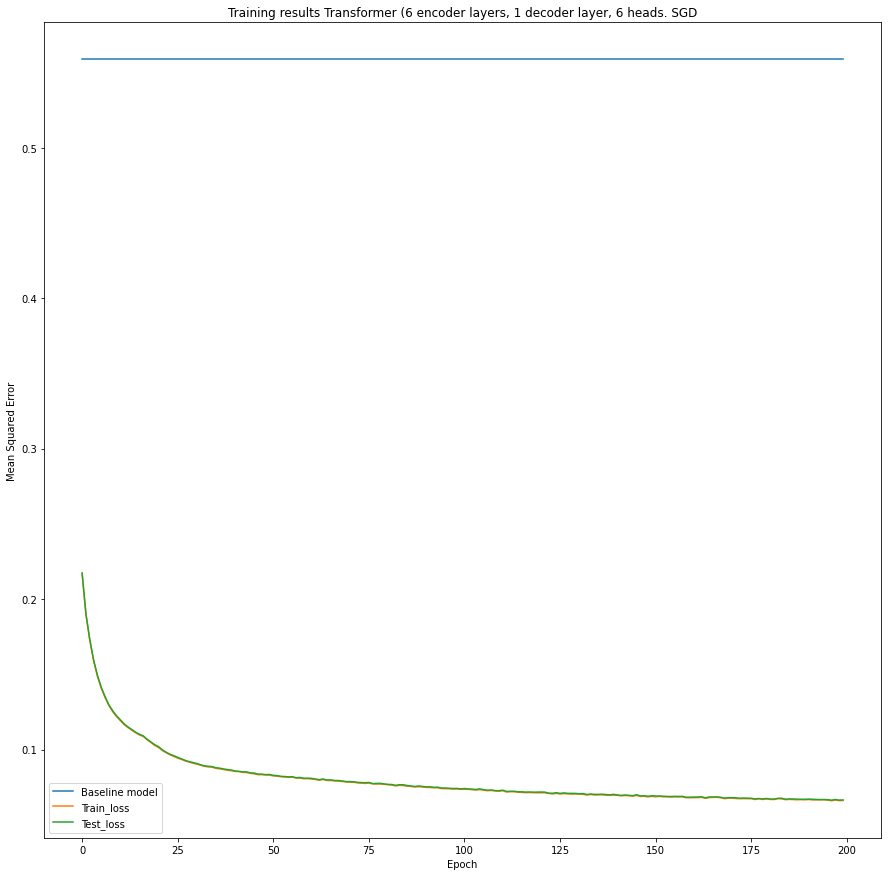

In [42]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure(figsize = (15,15))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  baseline = [base_line_loss for i in range(len(train_losses_1))]
  ax.plot(baseline, label= 'Baseline model')


  ax.plot([np.mean(i) for i in train_losses_1], label= 'Train_loss')
  ax.plot([np.mean(i) for i in test_losses_1], label= 'Test_loss')
  ax.set_title("Training results Transformer (6 encoder layers, 1 decoder layer, 6 heads. SGD")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()


  

In [ ]:
start_time = datetime.now()

# Initialize Transformer Model and Optimizer

continue_training = False

if continue_training is False:
  model_transformer_Adam = Transformer (num_encoder_layers=6,
                      num_decoder_layers=1,
                      feature_size=18,
                      output_size=18,
                      num_heads=6,
                      dim_feedforward=2048,
                      device = device,
                      batch_first=False)

n_epochs = 200

print('Setup model Ok')

optimizer = torch.optim.Adam(model_transformer_Adam.parameters(), lr=0.01)
criterion = nn.MSELoss()

print('Setup optimizer Ok')


train_transformer = True

if train_transformer is True:
  trained_model_transformer_Adam, train_losses_2, test_losses_2 = training_transformer(
      model= model_transformer_Adam, 
      optimizer= optimizer, 
      criterion= criterion, 
      train_loader= loader_train_seq, 
      test_loader= loader_test_seq, 
      n_epochs= n_epochs)

end_time = datetime.now()
time_diff = (end_time - start_time)
execution_time = time_diff.total_seconds() * 1000

print(f'{execution_time} miliseconds')

Setup model Ok
Setup optimizer Ok
Epoch: 1 of 200
Training...


100%|██████████| 1899/1899 [00:56<00:00, 33.58it/s]



Test with training set


100%|██████████| 1899/1899 [00:20<00:00, 94.06it/s]



Current Mean loss Train Set:  0.07137961384142431

Test with test set


100%|██████████| 211/211 [00:02<00:00, 93.71it/s]



Current Mean loss Test Set:  0.07149742644333161


Epoch: 2 of 200
Training...


100%|██████████| 1899/1899 [00:55<00:00, 34.03it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 97.49it/s]



Current Mean loss Train Set:  0.07953984600311835

Test with test set


100%|██████████| 211/211 [00:02<00:00, 98.94it/s] 



Current Mean loss Test Set:  0.07928192832670505


Epoch: 3 of 200
Training...


100%|██████████| 1899/1899 [00:55<00:00, 34.28it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 97.08it/s]



Current Mean loss Train Set:  0.0658415628007646

Test with test set


100%|██████████| 211/211 [00:02<00:00, 99.82it/s] 



Current Mean loss Test Set:  0.0659525480244962


Epoch: 4 of 200
Training...


100%|██████████| 1899/1899 [00:54<00:00, 34.65it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.79it/s] 



Current Mean loss Train Set:  0.06625285912197222

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.78it/s]



Current Mean loss Test Set:  0.06665396621512576


Epoch: 5 of 200
Training...


100%|██████████| 1899/1899 [00:54<00:00, 34.75it/s]



Test with training set


100%|██████████| 1899/1899 [00:22<00:00, 85.09it/s]



Current Mean loss Train Set:  0.05854615851306896

Test with test set


100%|██████████| 211/211 [00:02<00:00, 83.56it/s]



Current Mean loss Test Set:  0.058839741758825656


Epoch: 6 of 200
Training...


100%|██████████| 1899/1899 [00:54<00:00, 34.56it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 99.99it/s]



Current Mean loss Train Set:  0.0620089449427861

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.96it/s]



Current Mean loss Test Set:  0.06263724760421645


Epoch: 7 of 200
Training...


100%|██████████| 1899/1899 [00:54<00:00, 34.63it/s]



Test with training set


100%|██████████| 1899/1899 [00:21<00:00, 86.53it/s]



Current Mean loss Train Set:  0.059723324118365485

Test with test set


100%|██████████| 211/211 [00:02<00:00, 91.60it/s]



Current Mean loss Test Set:  0.06024029769744918


Epoch: 8 of 200
Training...


100%|██████████| 1899/1899 [00:54<00:00, 34.68it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.00it/s]



Current Mean loss Train Set:  0.0579341291114021

Test with test set


100%|██████████| 211/211 [00:02<00:00, 78.96it/s]



Current Mean loss Test Set:  0.058847155121830405


Epoch: 9 of 200
Training...


100%|██████████| 1899/1899 [00:54<00:00, 34.68it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.88it/s]



Current Mean loss Train Set:  0.06487011700366409

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.53it/s]



Current Mean loss Test Set:  0.06478771920452751


Epoch: 10 of 200
Training...


100%|██████████| 1899/1899 [00:54<00:00, 34.68it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.77it/s]



Current Mean loss Train Set:  0.06056272338736428

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.91it/s]



Current Mean loss Test Set:  0.06080849053806038


Epoch: 11 of 200
Training...


100%|██████████| 1899/1899 [00:54<00:00, 34.75it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 99.71it/s] 



Current Mean loss Train Set:  0.05438077813401826

Test with test set


100%|██████████| 211/211 [00:02<00:00, 97.27it/s]



Current Mean loss Test Set:  0.054698011674587196


Epoch: 12 of 200
Training...


100%|██████████| 1899/1899 [00:54<00:00, 34.54it/s]



Test with training set


100%|██████████| 1899/1899 [00:19<00:00, 98.77it/s] 



Current Mean loss Train Set:  0.059746808010992594

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.07it/s]



Current Mean loss Test Set:  0.06025253245121495


Epoch: 13 of 200
Training...


100%|██████████| 1899/1899 [00:54<00:00, 34.75it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.32it/s]



Current Mean loss Train Set:  0.06248445611539296

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.98it/s]



Current Mean loss Test Set:  0.06232427636170274


Epoch: 14 of 200
Training...


100%|██████████| 1899/1899 [00:54<00:00, 34.86it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 101.57it/s]



Current Mean loss Train Set:  0.057772950944601074

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.76it/s]



Current Mean loss Test Set:  0.05805650713601949


Epoch: 15 of 200
Training...


100%|██████████| 1899/1899 [00:54<00:00, 34.97it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 101.09it/s]



Current Mean loss Train Set:  0.058683381330078686

Test with test set


100%|██████████| 211/211 [00:02<00:00, 100.09it/s]



Current Mean loss Test Set:  0.05915780716809616


Epoch: 16 of 200
Training...


100%|██████████| 1899/1899 [00:54<00:00, 34.90it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.67it/s]



Current Mean loss Train Set:  0.05589877767169582

Test with test set


100%|██████████| 211/211 [00:02<00:00, 102.68it/s]



Current Mean loss Test Set:  0.05629749574932442


Epoch: 17 of 200
Training...


100%|██████████| 1899/1899 [00:54<00:00, 34.89it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 100.77it/s]



Current Mean loss Train Set:  0.05527191240930947

Test with test set


100%|██████████| 211/211 [00:02<00:00, 99.85it/s]



Current Mean loss Test Set:  0.0552614843781808


Epoch: 18 of 200
Training...


100%|██████████| 1899/1899 [00:54<00:00, 34.86it/s]



Test with training set


100%|██████████| 1899/1899 [00:18<00:00, 101.07it/s]



Current Mean loss Train Set:  0.0565518061088505

Test with test set


100%|██████████| 211/211 [00:02<00:00, 101.21it/s]



Current Mean loss Test Set:  0.05670940883069242


Epoch: 19 of 200
Training...


100%|██████████| 1899/1899 [00:54<00:00, 34.85it/s]



Test with training set


 79%|███████▊  | 1491/1899 [00:14<00:04, 97.97it/s]

In [ ]:
if train_transformer is True:

  # Show results of the loss function

  fig = plt.figure(figsize = (15,15))

  ax = fig.add_subplot(111)
  plt.ion()

  fig.show()
  fig.canvas.draw()

  baseline = [base_line_loss for i in range(len(train_losses_2))]
  ax.plot(baseline, label= 'Baseline model')
  ax.plot([np.mean(i) for i in test_losses_1], label= 'Test_loss SGD')


  ax.plot([np.mean(i) for i in train_losses_2], label= 'Train_loss Adam')
  ax.plot([np.mean(i) for i in test_losses_2], label= 'Test_loss Adam')
  ax.set_title("Training results Transformer (6 encoder layers, 1 decoder layer, 6 heads. Adam")
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Mean Squared Error')
  ax.legend()
  fig.canvas.draw()